In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# FC PLS

In [88]:
import numpy as np
import pandas as pd
import glob
import re
import os
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Config / user options
# ------------------------
grad_csv_path = './g1_aligned_cog.csv'   # CSV with metadata & behavior
fc_dir_glob = "./BD-SCZ/RSFC_HC_SCZ_BD_noGSR/sub*.mat"  # pattern to FC .mat files
pid_column_candidates = ['participant_id_num', 'participant_id', 'ID', 'id']  # try these
n_nodes_expected = 400   # expected FC matrix size; will validate
apply_fisher = True      # apply atanh to correlation values before analysis

# ------------------------
# Helper functions
# ------------------------
def ensure_numeric_encoding(df, col):
    """Deterministic numeric encoding for categorical columns."""
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in dataframe.")
    if np.issubdtype(df[col].dtype, np.number):
        return df
    # handle common gender variants
    if col.lower() == 'gender':
        mapping_candidates = {'male': 0, 'm': 0, 'female': 1, 'f': 1}
        unique_vals = pd.Series(df[col].dropna().astype(str).str.lower().unique())
        if set(unique_vals).issubset(set(mapping_candidates.keys())):
            mapping = {}
            for v in unique_vals:
                mapping_val = mapping_candidates.get(v)
                if mapping_val is None:
                    # fallback to deterministic ordinal
                    mapping[v] = int(pd.factorize(unique_vals)[0][unique_vals.tolist().index(v)])
                else:
                    mapping[v] = mapping_val
            # map using lower-cased strings
            df[col] = df[col].astype(str).str.lower().map(mapping)
            print(f"Auto-mapped '{col}' (gender-special): {mapping}")
            return df
    # generic deterministic mapping (sorted unique)
    uniques = sorted(df[col].dropna().astype(str).unique())
    mapping = {val: i for i, val in enumerate(uniques)}
    df[col] = df[col].astype(str).map(mapping)
    print(f"Auto-mapped '{col}': {mapping}")
    return df

def regress_out(X, covariates):
    """
    Regress out covariates from each column of X.
    X: (n_subjects, n_features)
    covariates: (n_subjects, k)
    Returns residualized X of same shape (float).
    """
    X = np.asarray(X, dtype=float)
    covariates = np.asarray(covariates, dtype=float)
    if covariates.ndim == 1:
        covariates = covariates.reshape(-1, 1)
    # Add intercept column if not present (LinearRegression will handle intercept by default)
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        y = X[:, j]
        lr = LinearRegression().fit(covariates, y)
        y_pred = lr.predict(covariates)
        X_resid[:, j] = y - y_pred
    return X_resid

# ------------------------
# Define cognitive groupings & other vars
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']
covariate_cols = ['age', 'gender']

# ------------------------
# Load gradient CSV (for metadata + behavior)
# ------------------------
grad_df = pd.read_csv(grad_csv_path)
print(f"Loaded gradient CSV: {grad_csv_path} (shape: {grad_df.shape})")

# detect participant id column
pid_col = None
for c in pid_column_candidates:
    if c in grad_df.columns:
        pid_col = c
        break
if pid_col is None:
    # fallback: detect first column where all non-null entries are integers when cast to string
    for c in grad_df.columns:
        nonnull = grad_df[c].dropna().astype(str)
        if nonnull.apply(lambda s: bool(re.fullmatch(r'\d+', s))).all():
            pid_col = c
            break
if pid_col is None:
    raise ValueError("Could not detect participant ID column in gradient CSV. "
                     "Please ensure a 'participant_id' or 'ID' column exists, or set pid_column_candidates.")
print(f"Using participant id column: '{pid_col}'")

# normalize participant_id column to string (remove trailing .0 etc.)
grad_df[pid_col] = grad_df[pid_col].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()

# ------------------------
# Load FC matrices safely
# ------------------------
files = np.sort(glob.glob(fc_dir_glob))
if len(files) == 0:
    raise FileNotFoundError(f"No FC files found with pattern: {fc_dir_glob}")

fc = {}
for f in files:
    try:
        matdict = loadmat(f)
    except Exception as e:
        print(f"Error loading {f} with scipy.io.loadmat: {e}. Skipping.")
        continue
    # check key
    if 'subj_final_corr_mat' not in matdict:
        print(f"Warning: 'subj_final_corr_mat' not found in {f}. Keys present: {list(matdict.keys())}. Skipping.")
        continue
    mat = matdict['subj_final_corr_mat']
    if mat is None:
        print(f"Warning: subj_final_corr_mat is None in {f}. Skipping.")
        continue
    mat = np.asarray(mat, dtype=float)
    # ensure 2D square
    if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
        print(f"Warning: FC matrix in {f} is not square (shape {mat.shape}). Skipping.")
        continue
    if mat.shape[0] < n_nodes_expected:
        print(f"Warning: FC matrix in {f} has fewer nodes ({mat.shape[0]}) than expected ({n_nodes_expected}). Skipping.")
        continue
    # crop or validate exact size
    if mat.shape[0] != n_nodes_expected:
        mat = mat[:n_nodes_expected, :n_nodes_expected]

    # optional: ensure symmetry (average with transpose)
    if not np.allclose(mat, mat.T, atol=1e-6):
        # symmetrize to be safe
        mat = 0.5 * (mat + mat.T)

    # extract pid from filename (digits after 'sub' or 'sub-')
    match = re.search(r"sub-?(\d+)", os.path.basename(f))
    if not match:
        print(f"Could not extract participant ID from {f}. Skipping.")
        continue
    pid = match.group(1)
    pid = pid.lstrip('0') or match.group(1)  # keep as digits but allow leading zeros removed
    fc[pid] = mat
    print(f"Loaded {os.path.basename(f)} -> pid {pid}, shape {mat.shape}")

print(f"Total FC files successfully loaded: {len(fc)}")

# ------------------------
# Match participants between grad metadata and FCs
# ------------------------
available_pids = set(fc.keys())
print(f"Participants in FC folder: {len(available_pids)}")

# Filter metadata to diagnosis 2 and 3 and available FCs
if 'diagnosis' not in grad_df.columns:
    raise KeyError("Expected 'diagnosis' in gradient CSV but not found.")
patient_df = grad_df[grad_df['diagnosis'].isin([2, 3]) & grad_df[pid_col].isin(available_pids)].copy()
print(f"Participants after diagnosis (2/3) & FC availability filter: {patient_df.shape[0]}")

if patient_df.shape[0] == 0:
    raise RuntimeError("No overlapping participants found between gradient metadata and FC files "
                       "after applying diagnosis filter. Check IDs and diagnosis coding.")

# Ensure categorical vars numeric
for col in ['gender', 'diagnosis']:
    patient_df = ensure_numeric_encoding(patient_df, col)

# ------------------------
# Build FC feature matrix (vectorized upper triangle)
# ------------------------
# canonical n_nodes
first_pid = next(iter(fc))
n_nodes = fc[first_pid].shape[0]
iu = np.triu_indices(n_nodes, k=1)
n_edges = len(iu[0])
print(f"Detected FC node count: {n_nodes}, edges (upper-triangle without diag): {n_edges}")

X_list = []
pids_used = []

# ensure patient_df pids align in type/format to fc keys (both strings)
patient_df[pid_col] = patient_df[pid_col].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()

for pid in patient_df[pid_col]:
    if pid not in fc:
        # try removing leading zeros / adding them — attempt a few fallbacks
        pid_int = pid.lstrip('0')
        if pid_int in fc:
            mat = fc[pid_int]
            chosen_pid = pid_int
        else:
            print(f"Warning: participant {pid} missing FC matrix, skipping.")
            continue
    else:
        mat = fc[pid]
        chosen_pid = pid
    if mat.shape[0] != n_nodes:
        raise ValueError(f"FC matrix node count mismatch for pid {chosen_pid} (expected {n_nodes}, got {mat.shape[0]})")
    # optionally apply Fisher z (atanh) — avoid infinite values if correlation = +-1
    if apply_fisher:
        # clip correlations slightly inside (-1, 1)
        mat_clip = np.clip(mat, -0.999999, 0.999999)
        mat_used = np.arctanh(mat_clip)
    else:
        mat_used = mat
    X_list.append(mat_used[iu])
    pids_used.append(chosen_pid)

if len(X_list) == 0:
    raise RuntimeError("No FC data available for selected participants after matching. Exiting.")

X = np.vstack(X_list)
print(f"Built FC feature matrix X with shape: {X.shape} (subjects x edges)")

# Reindex patient_df to the used pids and keep order consistent with X
patient_df = patient_df.set_index(pid_col).loc[pids_used].reset_index()
assert patient_df.shape[0] == X.shape[0]

# ------------------------
# Create cognitive domain scores
# ------------------------
# Validate cognitive variables exist in patient_df
for group_name, var_list in group_definitions.items():
    missing = [v for v in var_list if v not in patient_df.columns]
    if missing:
        raise KeyError(f"Missing cognitive variables for domain '{group_name}': {missing}")

for group_name, var_list in group_definitions.items():
    # Z-score each cognitive variable (column-wise) then average; invert so higher = worse
    # use ddof=0 consistent with population std for column-wise z
    zscored = patient_df[var_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
    domain_score = -zscored.mean(axis=1)
    patient_df[group_name] = domain_score

# ------------------------
# Build Y (behavioral + clinical)
# ------------------------
missing_other = [v for v in other_vars if v not in patient_df.columns]
if missing_other:
    raise KeyError(f"Missing clinical/behavioral variables: {missing_other}")

Y_cols = other_vars + list(group_definitions.keys())
Y = patient_df[Y_cols].values
print(f"Built Y with shape: {Y.shape} (subjects x behavioral_vars)")

# ------------------------
# Remove any subjects with missing data in X or Y
# ------------------------
nan_rows_X = np.isnan(X).any(axis=1)
nan_rows_Y = np.isnan(Y).any(axis=1)
valid_mask = ~(nan_rows_X | nan_rows_Y)

n_before = X.shape[0]
X_valid = X[valid_mask]
Y_valid = Y[valid_mask]
patient_df_valid = patient_df.loc[valid_mask].reset_index(drop=True)
n_after = X_valid.shape[0]
print(f"Removed {n_before - n_after} subjects with NaNs. Remaining subjects: {n_after}")

if n_after < 5:
    print("Warning: very few subjects remain after removing NaNs — PLS results may be unstable.")

# ------------------------
# Regress out age and gender from X (per edge)
# ------------------------
missing_cov = [c for c in covariate_cols if c not in patient_df_valid.columns]
if missing_cov:
    raise KeyError(f"Missing covariate columns required for regression: {missing_cov}")

covars = patient_df_valid[covariate_cols].values
X_resid = regress_out(X_valid, covars)
print("Regressed out covariates from X (age, gender).")

# ------------------------
# Standardize (z-score) both X and Y (column-wise)
# ------------------------
X_std = StandardScaler().fit_transform(X_resid)
Y_std = StandardScaler().fit_transform(Y_valid)
print("Standardized X and Y.")

# ------------------------
# Fit Partial Least Squares (PLS) - 1 component (LV)
# ------------------------
pls = PLSRegression(n_components=1)
pls.fit(X_std, Y_std)

# Saliences (weights) for X and Y
X_saliences = pls.x_weights_[:, 0]
Y_saliences = pls.y_weights_[:, 0]

# Subject scores (how much each subject expresses the LV pattern)
X_scores = pls.x_scores_[:, 0]
Y_scores = pls.y_scores_[:, 0]

# Correlate each behavioral variable with the LV behavioral score
behav_corrs = {}
behav_pvals = {}
for i, var in enumerate(Y_cols):
    try:
        corr, pval = pearsonr(Y_std[:, i], Y_scores)
    except Exception:
        corr, pval = np.nan, np.nan
    behav_corrs[var] = corr
    behav_pvals[var] = pval

# ------------------------
# Save results to a dictionary (for subsequent inspection)
# ------------------------
results = {
    'X_saliences': X_saliences,
    'Y_saliences': Y_saliences,
    'X_scores': X_scores,
    'Y_scores': Y_scores,
    'behav_corrs': behav_corrs,
    'behav_pvals': behav_pvals,
    'patient_df_valid': patient_df_valid,
    'X_std': X_std,
    'Y_std': Y_std,
    'pids_used': pids_used,
    'iu_indices': iu  # handy to reconstruct matrix from saliences
}

# ------------------------
# Print summary
# ------------------------
print("\nBehavioral correlations with LV (positive means higher behavior -> higher LV score; note domains were inverted so higher = worse):")
for var, corr in behav_corrs.items():
    pval = behav_pvals.get(var, np.nan)
    print(f"  {var:30s}: corr={np.round(corr, 3):6}   p={pval:.3g}")

print("\nDone. Results are stored in the `results` dict.")


Loaded gradient CSV: ./g1_aligned_cog.csv (shape: (187, 438))
Using participant id column: 'participant_id_num'
Loaded sub-10159_419ROIcorrMat.mat -> pid 10159, shape (400, 400)
Loaded sub-10189_419ROIcorrMat.mat -> pid 10189, shape (400, 400)
Loaded sub-10206_419ROIcorrMat.mat -> pid 10206, shape (400, 400)
Loaded sub-10217_419ROIcorrMat.mat -> pid 10217, shape (400, 400)
Loaded sub-10225_419ROIcorrMat.mat -> pid 10225, shape (400, 400)
Loaded sub-10227_419ROIcorrMat.mat -> pid 10227, shape (400, 400)
Loaded sub-10228_419ROIcorrMat.mat -> pid 10228, shape (400, 400)
Loaded sub-10249_419ROIcorrMat.mat -> pid 10249, shape (400, 400)
Loaded sub-10273_419ROIcorrMat.mat -> pid 10273, shape (400, 400)
Loaded sub-10274_419ROIcorrMat.mat -> pid 10274, shape (400, 400)
Loaded sub-10280_419ROIcorrMat.mat -> pid 10280, shape (400, 400)
Loaded sub-10290_419ROIcorrMat.mat -> pid 10290, shape (400, 400)
Loaded sub-10292_419ROIcorrMat.mat -> pid 10292, shape (400, 400)
Loaded sub-10304_419ROIcorrMat

## Loadings plot

Saved ./new_figures/LV1_salience_matrix.png


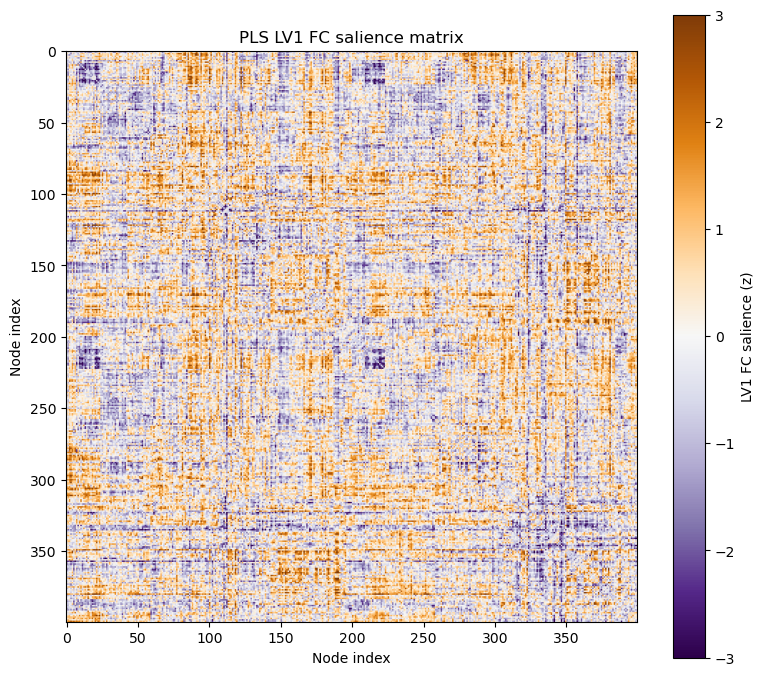

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("./new_figures", exist_ok=True)

# Extract data from results
X_saliences = results["X_saliences"]    # LV1 edge weights
iu = results["iu_indices"]              # upper-triangular indices
n_nodes = results["X_std"].shape[1]    # total features? careful
n_edges = len(iu[0])
# compute number of nodes from edges (optional check)
n_nodes = int(np.round((1 + np.sqrt(1 + 8 * n_edges)) / 2))

# Reconstruct full symmetric FC matrix
sal_mat = np.zeros((n_nodes, n_nodes))
sal_mat[iu] = X_saliences
sal_mat = sal_mat + sal_mat.T  # symmetric

# Optionally z-score for visualization
sal_mat_z = (sal_mat - np.nanmean(sal_mat)) / np.nanstd(sal_mat)

# Plot heatmap
plt.figure(figsize=(8, 7))
plt.imshow(sal_mat_z, cmap="PuOr_r", vmin=-3, vmax=3)
plt.colorbar(label="LV1 FC salience (z)")
plt.title("PLS LV1 FC salience matrix")
plt.xlabel("Node index")
plt.ylabel("Node index")
plt.tight_layout()

filename = './new_figures/LV1_salience_matrix.png'
plt.savefig(filename, dpi=150)
print(f"Saved {filename}")
plt.show()


## Permutation testing

In [90]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # or fewer for testing, e.g., 1000
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

print("Permutation testing for FC-based LV1...")

# Standardized X and Y from the single results dict
X = results['X_std']  # subjects × edges
Y = results['Y_std']  # subjects × behavioral vars

# -----------------------
# Fit original PLS
# -----------------------
pls = PLSRegression(n_components=n_components)
pls.fit(X, Y)

# Observed LV1 covariance (singular value)
X_scores = pls.x_scores_[:, 0]
Y_scores = pls.y_scores_[:, 0]
obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]

# -----------------------
# Run permutations
# -----------------------
perm_singular_values = np.zeros(n_permutations)
for i in range(n_permutations):
    # Shuffle rows of X
    X_perm = X[np.random.permutation(X.shape[0]), :]
    pls_perm = PLSRegression(n_components=n_components)
    pls_perm.fit(X_perm, Y)
    X_scores_perm = pls_perm.x_scores_[:, 0]
    Y_scores_perm = pls_perm.y_scores_[:, 0]
    perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Optional: progress print
    if (i + 1) % 1000 == 0:
        print(f"  {i + 1} permutations done...")

# -----------------------
# Compute permutation p-value
# -----------------------
p_value = np.mean(perm_singular_values >= obs_singular_value)

# Store results in a dict (single FC result)
results_perm = {
    'obs_singular_value': obs_singular_value,
    'perm_singular_values': perm_singular_values,
    'p_value': p_value
}

print(f"FC LV1 permutation p-value: {p_value:.4f}")


Permutation testing for FC-based LV1...
  1000 permutations done...
  2000 permutations done...
  3000 permutations done...
  4000 permutations done...
  5000 permutations done...
  6000 permutations done...
  7000 permutations done...
  8000 permutations done...
  9000 permutations done...
  10000 permutations done...
FC LV1 permutation p-value: 0.5006


## Bootstrap resampling

Bootstrap resampling for FC-based LV1...
  500 / 5000 bootstraps done
  1000 / 5000 bootstraps done
  1500 / 5000 bootstraps done
  2000 / 5000 bootstraps done
  2500 / 5000 bootstraps done
  3000 / 5000 bootstraps done
  3500 / 5000 bootstraps done
  4000 / 5000 bootstraps done
  4500 / 5000 bootstraps done
  5000 / 5000 bootstraps done


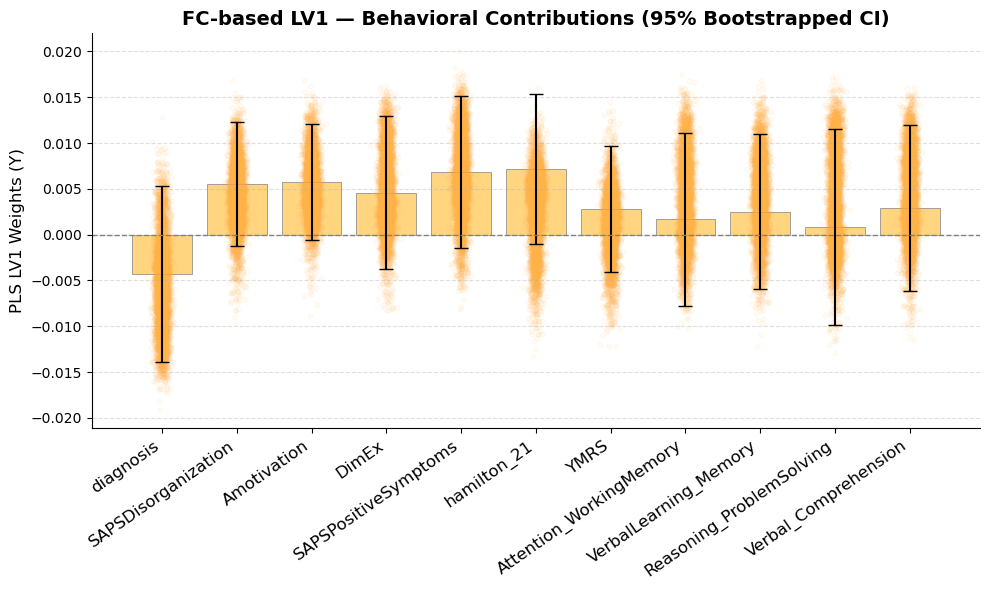

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000   # or fewer for testing, e.g., 1000
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap results

# Plot colors
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

print("Bootstrap resampling for FC-based LV1...")

# Standardized X and Y
X = results['X_std']  # subjects × edges
Y = results['Y_std']  # subjects × behavioral vars
n_subjects, n_edges = X.shape
n_behav = Y.shape[1]

# -----------------------
# Original PLS fit
# -----------------------
pls_orig = PLSRegression(n_components=n_components)
pls_orig.fit(X, Y)
X_orig_weights = pls_orig.x_weights_[:, 0]
Y_orig_weights = pls_orig.y_weights_[:, 0]

# -----------------------
# Bootstrap resampling
# -----------------------
X_boot_weights = np.zeros((n_bootstrap, n_edges))
Y_boot_weights = np.zeros((n_bootstrap, n_behav))

for i in range(n_bootstrap):
    # Resample subjects with replacement
    Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

    pls_boot = PLSRegression(n_components=n_components)
    pls_boot.fit(Xb, Yb)
    Xb_weights = pls_boot.x_weights_[:, 0]
    Yb_weights = pls_boot.y_weights_[:, 0]

    # -----------------------
    # Sign alignment (flip if reversed)
    # -----------------------
    if np.dot(Xb_weights, X_orig_weights) < 0:
        Xb_weights *= -1
        Yb_weights *= -1

    X_boot_weights[i, :] = Xb_weights
    Y_boot_weights[i, :] = Yb_weights

    if (i + 1) % 500 == 0:
        print(f"  {i + 1} / {n_bootstrap} bootstraps done")

# -----------------------
# Bootstrap ratios (BSR = weight / SD)
# -----------------------
X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

results_boot = {
    'X_bsr': X_bsr,
    'Y_bsr': Y_bsr,
    'X_boot_weights': X_boot_weights,
    'Y_boot_weights': Y_boot_weights
}

# -----------------------
# Behavioral bootstrap visualization (Y weights)
# -----------------------
y_mean = Y_orig_weights
y_sd = Y_boot_weights.std(axis=0)
lower_ci = y_mean - 1.96 * y_sd
upper_ci = y_mean + 1.96 * y_sd
significant = (lower_ci > 0) | (upper_ci < 0)

Y_cols = list(results['behav_corrs'].keys())
fig, ax = plt.subplots(figsize=(10, 6))

# Bars with error bars
ax.bar(
    np.arange(n_behav), y_mean,
    width=0.8,
    yerr=[y_mean - lower_ci, upper_ci - y_mean],
    capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5
)

# Overlay bootstrap points (for distribution)
for j in range(n_behav):
    x = np.random.normal(j, 0.05, size=n_bootstrap)
    ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

# Zero line
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Significance stars
for j, sig in enumerate(significant):
    if sig:
        ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                fontsize=14, color=star_color, fontweight='bold')

ax.set_xticks(np.arange(n_behav))
ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
ax.set_title('FC-based LV1 — Behavioral Contributions (95% Bootstrapped CI)',
             fontsize=14, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


## Variance explained

Computing variance explained for FC-based PLS LV1...
LV1 explains 12.58% of X variance, 8.04% of Y variance, and 1743.89% shared variance.



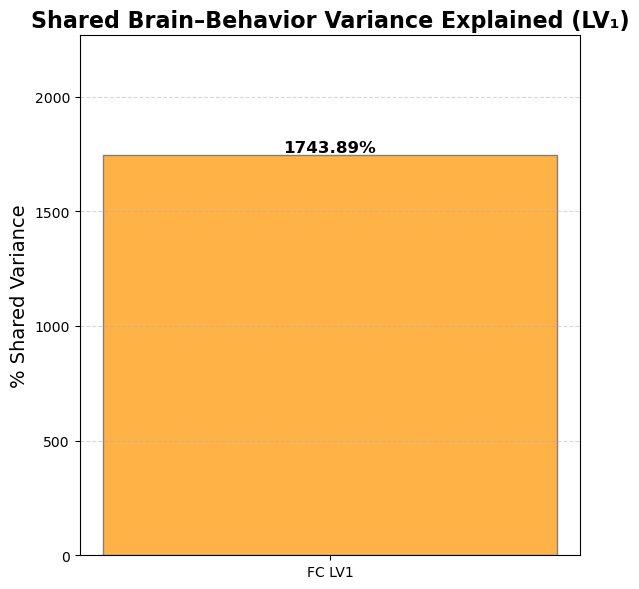

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for FC-based PLS LV1...")

X = results['X_std']
Y = results['Y_std']

pls = PLSRegression(n_components=1)
pls.fit(X, Y)

# Reconstruct predicted X and Y
X_pred = pls.x_scores_ @ pls.x_loadings_.T
Y_pred = pls.x_scores_ @ pls.y_loadings_.T

# Variance explained within each block
var_X = np.var(X, axis=0).sum()
var_Y = np.var(Y, axis=0).sum()
var_X_expl = np.var(X_pred, axis=0).sum() / var_X
var_Y_expl = np.var(Y_pred, axis=0).sum() / var_Y

# Shared cross-covariance variance explained
shared_var = (pls.x_scores_.T @ pls.y_scores_)**2 / (np.sum(X**2) * np.sum(Y**2))
shared_var = shared_var.item()

# Store in results dict
results['var_X_expl'] = var_X_expl
results['var_Y_expl'] = var_Y_expl
results['shared_var'] = shared_var

print(f"LV1 explains {var_X_expl * 100:.2f}% of X variance, "
      f"{var_Y_expl * 100:.2f}% of Y variance, "
      f"and {shared_var * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
plt.figure(figsize=(6, 6))
vals = [shared_var * 100]
plt.bar(['FC LV1'], vals, color=['#FFB347'], edgecolor='gray')

for i, v in enumerate(vals):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.ylim(0, max(vals) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1.png", dpi=300)
plt.show()


## New variance explained

Computing variance explained for FC-based PLS LV1...
LV1 explains 12.58% of X variance, 8.04% of Y variance, 79.18% of total X–Y cross-covariance energy, and t–u squared correlation = 30.07%



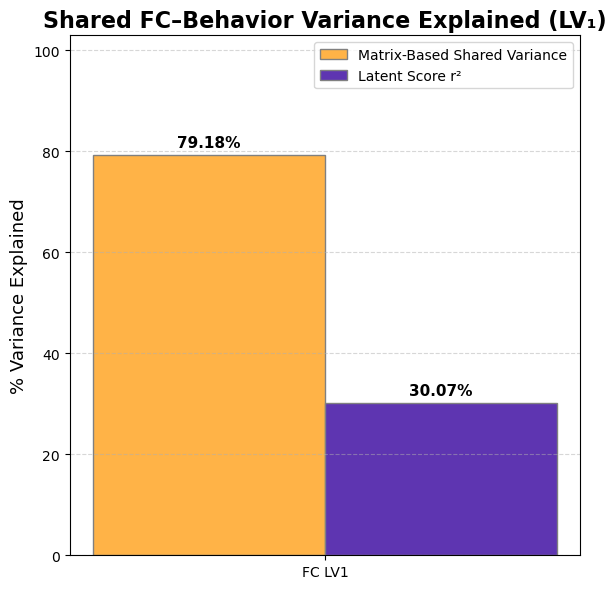


Saved figure to: new_figures/shared_variance_combined_FC_LV1.png


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# Create output folder
os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for FC-based PLS LV1...")

X = results['X_std']  # subjects × edges
Y = results['Y_std']  # subjects × behavioral vars
n_samples = X.shape[0]

pls = PLSRegression(n_components=1)
pls.fit(X, Y)

# Predicted components
X_pred = pls.x_scores_ @ pls.x_loadings_.T
Y_pred = pls.x_scores_ @ pls.y_loadings_.T

# Variance explained
var_X_expl = np.sum(X_pred**2) / np.sum(X**2)
var_Y_expl = np.sum(Y_pred**2) / np.sum(Y**2)

# Shared variance (matrix-based)
C_full = (X.T @ Y) / (n_samples - 1)
C_pred = (X_pred.T @ Y_pred) / (n_samples - 1)
total_cross_energy = np.sum(C_full**2)
explained_cross_energy = np.sum(C_pred**2)
shared_var_matrix = 0.0 if total_cross_energy == 0 else explained_cross_energy / total_cross_energy

# Latent score correlation (t–u)
t = pls.x_scores_[:, 0]
u = pls.y_scores_[:, 0]
r2_latent = np.corrcoef(t, u)[0, 1]**2

# Store in results dict
results['var_X_expl'] = var_X_expl
results['var_Y_expl'] = var_Y_expl
results['shared_var_matrix'] = shared_var_matrix
results['r2_latent'] = r2_latent

print(f"LV1 explains {var_X_expl*100:.2f}% of X variance, "
      f"{var_Y_expl*100:.2f}% of Y variance, "
      f"{shared_var_matrix*100:.2f}% of total X–Y cross-covariance energy, "
      f"and t–u squared correlation = {r2_latent*100:.2f}%\n")

# --- Plot combined bars ---
vals_matrix = [shared_var_matrix * 100]
vals_latent = [r2_latent * 100]
labels = ['FC LV1']

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 6))
plt.bar(x - width/2, vals_matrix, width, label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray')
plt.bar(x + width/2, vals_latent, width, label='Latent Score r²',
        color='#5E35B1', edgecolor='gray')

# Annotate
for i in range(len(labels)):
    plt.text(x[i] - width/2, vals_matrix[i] + 1, f"{vals_matrix[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, vals_latent[i] + 1, f"{vals_latent[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, labels)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared FC–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylim(0, max(vals_matrix[0], vals_latent[0]) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_FC_LV1.png", dpi=300)
plt.show()

print("\nSaved figure to: new_figures/shared_variance_combined_FC_LV1.png")


# Upper 10% FC

In [101]:
import numpy as np
import pandas as pd
import glob
import re
import os
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Config / options
# ------------------------
grad_csv_path = './g1_aligned_cog.csv'
fc_dir_glob = "./BD-SCZ/RSFC_HC_SCZ_BD_noGSR/sub*.mat"
pid_column_candidates = ['participant_id_num', 'participant_id', 'ID', 'id']
n_nodes_expected = 400
apply_fisher = True
top_percent = 0.1  # keep top 10% strongest FC edges

# ------------------------
# Helper functions
# ------------------------
def ensure_numeric_encoding(df, col):
    if col.lower() == 'gender':
        mapping_candidates = {'male': 0, 'm': 0, 'female': 1, 'f': 1}
        uniques = pd.Series(df[col].dropna().astype(str).str.lower().unique())
        mapping = {val: mapping_candidates.get(val, i) for i, val in enumerate(uniques)}
        df[col] = df[col].astype(str).str.lower().map(mapping)
        return df
    uniques = sorted(df[col].dropna().astype(str).unique())
    df[col] = df[col].astype(str).map({v:i for i,v in enumerate(uniques)})
    return df

def regress_out(X, covariates):
    X = np.asarray(X, dtype=float)
    covariates = np.asarray(covariates, dtype=float)
    if covariates.ndim == 1:
        covariates = covariates.reshape(-1, 1)
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        y = X[:, j]
        lr = LinearRegression().fit(covariates, y)
        X_resid[:, j] = y - lr.predict(covariates)
    return X_resid

# ------------------------
# Load metadata
# ------------------------
grad_df = pd.read_csv(grad_csv_path)
pid_col = next((c for c in pid_column_candidates if c in grad_df.columns), None)
grad_df[pid_col] = grad_df[pid_col].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()

# ------------------------
# Load FC matrices
# ------------------------
files = np.sort(glob.glob(fc_dir_glob))
fc_data = {}
for f in files:
    try:
        mat = np.asarray(loadmat(f)['subj_final_corr_mat'], dtype=float)
        if mat.shape[0] != n_nodes_expected:
            mat = mat[:n_nodes_expected, :n_nodes_expected]
        if not np.allclose(mat, mat.T, atol=1e-6):
            mat = 0.5 * (mat + mat.T)
        pid = re.search(r"sub-?(\d+)", os.path.basename(f)).group(1).lstrip('0')
        fc_data[pid] = mat
    except:
        continue

# ------------------------
# Match participants
# ------------------------
patient_df = grad_df[grad_df['diagnosis'].isin([2,3]) & grad_df[pid_col].isin(fc_data.keys())].copy()
for col in ['gender', 'diagnosis']:
    patient_df = ensure_numeric_encoding(patient_df, col)

# ------------------------
# Build FC matrix: top 10% edges (absolute) consistent across subjects
# ------------------------
iu = np.triu_indices(n_nodes_expected, k=1)
n_edges = len(iu[0])
top_n_edges = int(n_edges * top_percent)

all_edges = np.vstack([np.abs(fc_data[pid][iu]) for pid in patient_df[pid_col]])
threshold = np.percentile(all_edges, 100 - top_percent*100)

mask_top_edges = np.any(np.abs(all_edges) >= threshold, axis=0)  # same mask for all

X_top = np.vstack([np.arctanh(np.clip(fc_data[pid][iu], -0.999999, 0.999999))[mask_top_edges]
                   for pid in patient_df[pid_col]])

# ------------------------
# Reindex patient_df
# ------------------------
patient_df = patient_df.set_index(pid_col).loc[patient_df[pid_col]].reset_index()

# ------------------------
# Cognitive domain scores
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

for group, vars_list in group_definitions.items():
    z = patient_df[vars_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0))
    patient_df[group] = -z.mean(axis=1)

# ------------------------
# Y matrix
# ------------------------
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']
Y_cols = other_vars + list(group_definitions.keys())
Y_top = patient_df[Y_cols].values

# ------------------------
# Remove NaNs
# ------------------------
valid_mask = ~(np.isnan(X_top).any(axis=1) | np.isnan(Y_top).any(axis=1))
X_top = X_top[valid_mask]
Y_top = Y_top[valid_mask]
patient_df = patient_df.loc[valid_mask].reset_index(drop=True)

# ------------------------
# Regress covariates
# ------------------------
covars = patient_df[['age', 'gender']].values
X_top_resid = regress_out(X_top, covars)

# ------------------------
# Standardize
# ------------------------
X_top_std = StandardScaler().fit_transform(X_top_resid)
Y_top_std = StandardScaler().fit_transform(Y_top)

# ------------------------
# PLS LV1
# ------------------------
pls_top = PLSRegression(n_components=1)
pls_top.fit(X_top_std, Y_top_std)
X_top_saliences = pls_top.x_weights_[:,0]
Y_top_saliences = pls_top.y_weights_[:,0]
X_top_scores = pls_top.x_scores_[:,0]
Y_top_scores = pls_top.y_scores_[:,0]

# ------------------------
# Behavioral correlations
# ------------------------
behav_corrs_top = {var: pearsonr(Y_top_std[:,i], Y_top_scores)[0] for i,var in enumerate(Y_cols)}

# ------------------------
# Save results
# ------------------------
results_top10 = {
    'X_saliences': X_top_saliences,
    'Y_saliences': Y_top_saliences,
    'X_scores': X_top_scores,
    'Y_scores': Y_top_scores,
    'behav_corrs': behav_corrs_top,
    'patient_df_valid': patient_df,
    'X_std': X_top_std,
    'Y_std': Y_top_std,
    'pids_used': list(patient_df[pid_col]),
    'mask_top_edges': mask_top_edges,
    'iu_indices': iu
}

print("Top 10% FC LV1 PLS complete.")


Top 10% FC LV1 PLS complete.


## Permutation testing

In [115]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations_top10 = 10000  # or fewer for testing, e.g., 1000
n_components_top10 = 1         # LV1 only
results_perm_top10 = {}        # store permutation p-values

print("Permutation testing for Top 10% FC LV1...")

# Standardized X and Y from the top10% results
X_top10 = results_top10['X_std']  # subjects × top edges
Y_top10 = results_top10['Y_std']  # subjects × behavioral vars

# -----------------------
# Fit original PLS
# -----------------------
pls_top10 = PLSRegression(n_components=n_components_top10)
pls_top10.fit(X_top10, Y_top10)

# Observed LV1 covariance (singular value)
X_scores_top10 = pls_top10.x_scores_[:, 0]
Y_scores_top10 = pls_top10.y_scores_[:, 0]
obs_singular_value_top10 = np.cov(X_scores_top10, Y_scores_top10, bias=True)[0, 1]

# -----------------------
# Run permutations
# -----------------------
perm_singular_values_top10 = np.zeros(n_permutations_top10)
for i in range(n_permutations_top10):
    # Shuffle rows of X
    X_perm_top10 = X_top10[np.random.permutation(X_top10.shape[0]), :]
    pls_perm_top10 = PLSRegression(n_components=n_components_top10)
    pls_perm_top10.fit(X_perm_top10, Y_top10)
    X_scores_perm_top10 = pls_perm_top10.x_scores_[:, 0]
    Y_scores_perm_top10 = pls_perm_top10.y_scores_[:, 0]
    perm_singular_values_top10[i] = np.cov(X_scores_perm_top10, Y_scores_perm_top10, bias=True)[0, 1]

    # Optional: progress print
    if (i + 1) % 1000 == 0:
        print(f"  {i + 1} permutations done...")

# -----------------------
# Compute permutation p-value
# -----------------------
p_value_top10 = np.mean(perm_singular_values_top10 >= obs_singular_value_top10)

# Store results in a dict
results_perm_top10 = {
    'obs_singular_value': obs_singular_value_top10,
    'perm_singular_values': perm_singular_values_top10,
    'p_value': p_value_top10
}

print(f"Top 10% FC LV1 permutation p-value: {p_value_top10:.4f}")


Permutation testing for Top 10% FC LV1...
  1000 permutations done...
  2000 permutations done...
  3000 permutations done...
  4000 permutations done...
  5000 permutations done...
  6000 permutations done...
  7000 permutations done...
  8000 permutations done...
  9000 permutations done...
  10000 permutations done...
Top 10% FC LV1 permutation p-value: 0.5097


## Bootstrap resampling

Bootstrap resampling for Top 10% FC LV1...
  500 / 5000 bootstraps done
  1000 / 5000 bootstraps done
  1500 / 5000 bootstraps done
  2000 / 5000 bootstraps done
  2500 / 5000 bootstraps done
  3000 / 5000 bootstraps done
  3500 / 5000 bootstraps done
  4000 / 5000 bootstraps done
  4500 / 5000 bootstraps done
  5000 / 5000 bootstraps done


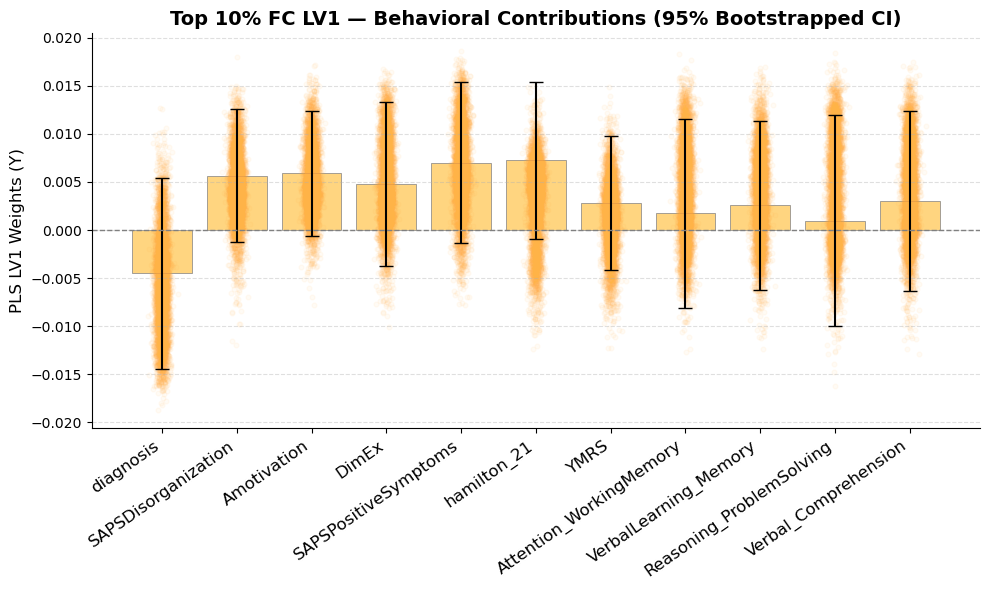

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap_top10 = 5000   # or fewer for testing, e.g., 1000
n_components_top10 = 1     # LV1 only
results_boot_top10 = {}    # store bootstrap results

# Plot colors
bar_color_top10 = '#FFD580'
point_color_top10 = '#FFB347'
star_color_top10 = 'black'

print("Bootstrap resampling for Top 10% FC LV1...")

# Standardized X and Y
X_top10 = results_top10['X_std']  # subjects × top edges
Y_top10 = results_top10['Y_std']  # subjects × behavioral vars
n_subjects_top10, n_edges_top10 = X_top10.shape
n_behav_top10 = Y_top10.shape[1]

# -----------------------
# Original PLS fit
# -----------------------
pls_orig_top10 = PLSRegression(n_components=n_components_top10)
pls_orig_top10.fit(X_top10, Y_top10)
X_orig_weights_top10 = pls_orig_top10.x_weights_[:, 0]
Y_orig_weights_top10 = pls_orig_top10.y_weights_[:, 0]

# -----------------------
# Bootstrap resampling
# -----------------------
X_boot_weights_top10 = np.zeros((n_bootstrap_top10, n_edges_top10))
Y_boot_weights_top10 = np.zeros((n_bootstrap_top10, n_behav_top10))

for i in range(n_bootstrap_top10):
    # Resample subjects with replacement
    Xb_top10, Yb_top10 = resample(X_top10, Y_top10, n_samples=n_subjects_top10, replace=True)

    pls_boot_top10 = PLSRegression(n_components=n_components_top10)
    pls_boot_top10.fit(Xb_top10, Yb_top10)
    Xb_weights_top10 = pls_boot_top10.x_weights_[:, 0]
    Yb_weights_top10 = pls_boot_top10.y_weights_[:, 0]

    # -----------------------
    # Sign alignment (flip if reversed)
    # -----------------------
    if np.dot(Xb_weights_top10, X_orig_weights_top10) < 0:
        Xb_weights_top10 *= -1
        Yb_weights_top10 *= -1

    X_boot_weights_top10[i, :] = Xb_weights_top10
    Y_boot_weights_top10[i, :] = Yb_weights_top10

    if (i + 1) % 500 == 0:
        print(f"  {i + 1} / {n_bootstrap_top10} bootstraps done")

# -----------------------
# Bootstrap ratios (BSR = weight / SD)
# -----------------------
X_bsr_top10 = X_orig_weights_top10 / X_boot_weights_top10.std(axis=0)
Y_bsr_top10 = Y_orig_weights_top10 / Y_boot_weights_top10.std(axis=0)

results_boot_top10 = {
    'X_bsr': X_bsr_top10,
    'Y_bsr': Y_bsr_top10,
    'X_boot_weights': X_boot_weights_top10,
    'Y_boot_weights': Y_boot_weights_top10
}

# -----------------------
# Behavioral bootstrap visualization (Y weights)
# -----------------------
y_mean_top10 = Y_orig_weights_top10
y_sd_top10 = Y_boot_weights_top10.std(axis=0)
lower_ci_top10 = y_mean_top10 - 1.96 * y_sd_top10
upper_ci_top10 = y_mean_top10 + 1.96 * y_sd_top10
significant_top10 = (lower_ci_top10 > 0) | (upper_ci_top10 < 0)

Y_cols_top10 = list(results_top10['behav_corrs'].keys())
fig, ax = plt.subplots(figsize=(10, 6))

# Bars with error bars
ax.bar(
    np.arange(n_behav_top10), y_mean_top10,
    width=0.8,
    yerr=[y_mean_top10 - lower_ci_top10, upper_ci_top10 - y_mean_top10],
    capsize=5, color=bar_color_top10, edgecolor='gray', linewidth=0.5
)

# Overlay bootstrap points (for distribution)
for j in range(n_behav_top10):
    x = np.random.normal(j, 0.05, size=n_bootstrap_top10)
    ax.scatter(x, Y_boot_weights_top10[:, j], color=point_color_top10, alpha=0.05, s=12)

# Zero line
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Significance stars
for j, sig in enumerate(significant_top10):
    if sig:
        ax.text(j, upper_ci_top10[j] + 0.02, "*", ha='center', va='bottom',
                fontsize=14, color=star_color_top10, fontweight='bold')

ax.set_xticks(np.arange(n_behav_top10))
ax.set_xticklabels(Y_cols_top10, rotation=35, ha='right', fontsize=12)
ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
ax.set_title('Top 10% FC LV1 — Behavioral Contributions (95% Bootstrapped CI)',
             fontsize=14, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


## Variance explained

Computing variance explained for Top 10% FC PLS LV1...
Top 10% FC LV1 explains 12.60% of X variance, 8.08% of Y variance, and 1646.12% shared variance.



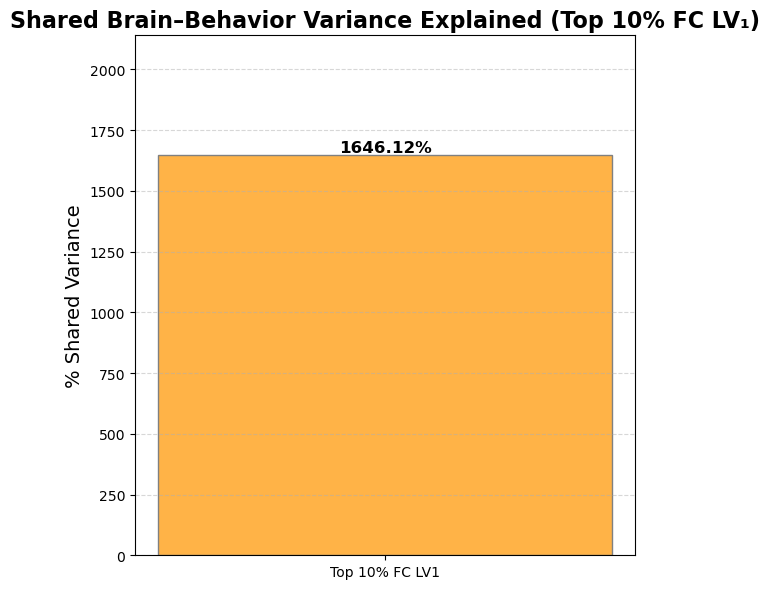

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for Top 10% FC PLS LV1...")

# Standardized X and Y for top 10% edges
X_top10 = results_top10['X_std']
Y_top10 = results_top10['Y_std']

# Fit PLS
pls_top10 = PLSRegression(n_components=1)
pls_top10.fit(X_top10, Y_top10)

# Reconstruct predicted X and Y
X_pred_top10 = pls_top10.x_scores_ @ pls_top10.x_loadings_.T
Y_pred_top10 = pls_top10.x_scores_ @ pls_top10.y_loadings_.T

# Variance explained within each block
var_X_top10 = np.var(X_top10, axis=0).sum()
var_Y_top10 = np.var(Y_top10, axis=0).sum()
var_X_expl_top10 = np.var(X_pred_top10, axis=0).sum() / var_X_top10
var_Y_expl_top10 = np.var(Y_pred_top10, axis=0).sum() / var_Y_top10

# Shared cross-covariance variance explained
shared_var_top10 = (pls_top10.x_scores_.T @ pls_top10.y_scores_)**2 / (np.sum(X_top10**2) * np.sum(Y_top10**2))
shared_var_top10 = shared_var_top10.item()

# Store in results_top10 dict
results_top10['var_X_expl'] = var_X_expl_top10
results_top10['var_Y_expl'] = var_Y_expl_top10
results_top10['shared_var'] = shared_var_top10

print(f"Top 10% FC LV1 explains {var_X_expl_top10 * 100:.2f}% of X variance, "
      f"{var_Y_expl_top10 * 100:.2f}% of Y variance, "
      f"and {shared_var_top10 * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
plt.figure(figsize=(6, 6))
vals_top10 = [shared_var_top10 * 100]
plt.bar(['Top 10% FC LV1'], vals_top10, color=['#FFB347'], edgecolor='gray')

for i, v in enumerate(vals_top10):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (Top 10% FC LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.ylim(0, max(vals_top10) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1_top10.png", dpi=300)
plt.show()


## New variance explained

Computing variance explained for Top 10% FC PLS LV1...
Top 10% FC LV1 explains 12.60% of X variance, 8.08% of Y variance, 79.96% of total X–Y cross-covariance energy, and t–u squared correlation = 30.04%



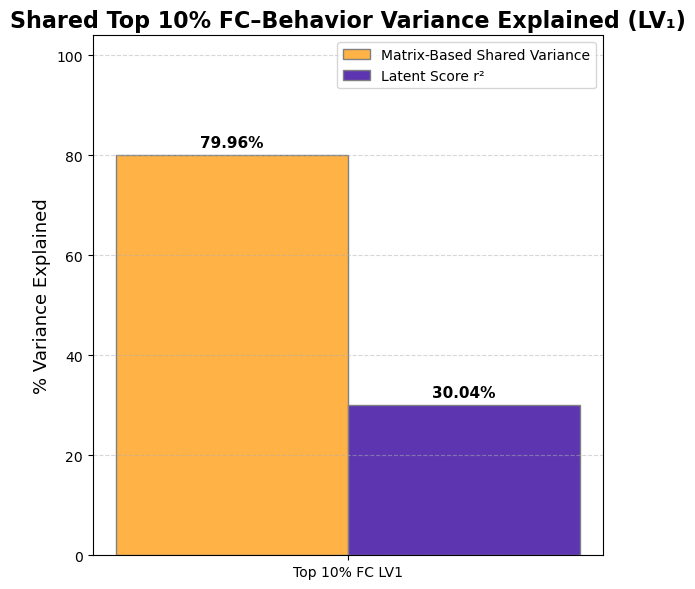


Saved figure to: new_figures/shared_variance_combined_FC_LV1_top10.png


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# Create output folder
os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for Top 10% FC PLS LV1...")

# Standardized X and Y for top 10% edges
X_top10 = results_top10['X_std']  # subjects × top 10% edges
Y_top10 = results_top10['Y_std']  # subjects × behavioral vars
n_samples_top10 = X_top10.shape[0]

# Fit PLS
pls_top10 = PLSRegression(n_components=1)
pls_top10.fit(X_top10, Y_top10)

# Predicted components
X_pred_top10 = pls_top10.x_scores_ @ pls_top10.x_loadings_.T
Y_pred_top10 = pls_top10.x_scores_ @ pls_top10.y_loadings_.T

# Variance explained
var_X_expl_top10 = np.sum(X_pred_top10**2) / np.sum(X_top10**2)
var_Y_expl_top10 = np.sum(Y_pred_top10**2) / np.sum(Y_top10**2)

# Shared variance (matrix-based)
C_full_top10 = (X_top10.T @ Y_top10) / (n_samples_top10 - 1)
C_pred_top10 = (X_pred_top10.T @ Y_pred_top10) / (n_samples_top10 - 1)
total_cross_energy_top10 = np.sum(C_full_top10**2)
explained_cross_energy_top10 = np.sum(C_pred_top10**2)
shared_var_matrix_top10 = 0.0 if total_cross_energy_top10 == 0 else explained_cross_energy_top10 / total_cross_energy_top10

# Latent score correlation (t–u)
t_top10 = pls_top10.x_scores_[:, 0]
u_top10 = pls_top10.y_scores_[:, 0]
r2_latent_top10 = np.corrcoef(t_top10, u_top10)[0, 1]**2

# Store in results_top10 dict
results_top10['var_X_expl'] = var_X_expl_top10
results_top10['var_Y_expl'] = var_Y_expl_top10
results_top10['shared_var_matrix'] = shared_var_matrix_top10
results_top10['r2_latent'] = r2_latent_top10

print(f"Top 10% FC LV1 explains {var_X_expl_top10*100:.2f}% of X variance, "
      f"{var_Y_expl_top10*100:.2f}% of Y variance, "
      f"{shared_var_matrix_top10*100:.2f}% of total X–Y cross-covariance energy, "
      f"and t–u squared correlation = {r2_latent_top10*100:.2f}%\n")

# --- Plot combined bars ---
vals_matrix_top10 = [shared_var_matrix_top10 * 100]
vals_latent_top10 = [r2_latent_top10 * 100]
labels_top10 = ['Top 10% FC LV1']

x = np.arange(len(labels_top10))
width = 0.35

plt.figure(figsize=(6, 6))
plt.bar(x - width/2, vals_matrix_top10, width, label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray')
plt.bar(x + width/2, vals_latent_top10, width, label='Latent Score r²',
        color='#5E35B1', edgecolor='gray')

# Annotate bars
for i in range(len(labels_top10)):
    plt.text(x[i] - width/2, vals_matrix_top10[i] + 1, f"{vals_matrix_top10[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, vals_latent_top10[i] + 1, f"{vals_latent_top10[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, labels_top10)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Top 10% FC–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylim(0, max(vals_matrix_top10[0], vals_latent_top10[0]) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_FC_LV1_top10.png", dpi=300)
plt.show()

print("\nSaved figure to: new_figures/shared_variance_combined_FC_LV1_top10.png")


# FC PLS without diagnosis 

In [119]:
import numpy as np
import pandas as pd
import glob
import re
import os
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Config / user options
# ------------------------
grad_csv_path = './g1_aligned_cog.csv'   
fc_dir_glob = "./BD-SCZ/RSFC_HC_SCZ_BD_noGSR/sub*.mat"  
pid_column_candidates = ['participant_id_num', 'participant_id', 'ID', 'id']  
n_nodes_expected = 400   
apply_fisher = True      

# ------------------------
# Helper functions
# ------------------------
def ensure_numeric_encoding(df, col):
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in dataframe.")
    if np.issubdtype(df[col].dtype, np.number):
        return df
    if col.lower() == 'gender':
        mapping_candidates = {'male': 0, 'm': 0, 'female': 1, 'f': 1}
        unique_vals = pd.Series(df[col].dropna().astype(str).str.lower().unique())
        if set(unique_vals).issubset(set(mapping_candidates.keys())):
            mapping = {v: mapping_candidates.get(v, i) for i, v in enumerate(unique_vals)}
            df[col] = df[col].astype(str).str.lower().map(mapping)
            print(f"Auto-mapped '{col}' (gender-special): {mapping}")
            return df
    uniques = sorted(df[col].dropna().astype(str).unique())
    mapping = {val: i for i, val in enumerate(uniques)}
    df[col] = df[col].astype(str).map(mapping)
    print(f"Auto-mapped '{col}': {mapping}")
    return df

def regress_out(X, covariates):
    X = np.asarray(X, dtype=float)
    covariates = np.asarray(covariates, dtype=float)
    if covariates.ndim == 1:
        covariates = covariates.reshape(-1, 1)
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        y = X[:, j]
        lr = LinearRegression().fit(covariates, y)
        X_resid[:, j] = y - lr.predict(covariates)
    return X_resid

# ------------------------
# Cognitive groupings & other vars
# ------------------------
group_definitions_nodx = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}
other_vars_nodx = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                    'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']  # diagnosis removed
covariate_cols_nodx = ['age', 'gender']

# ------------------------
# Load gradient CSV
# ------------------------
grad_df_nodx = pd.read_csv(grad_csv_path)
print(f"Loaded gradient CSV: {grad_csv_path} (shape: {grad_df_nodx.shape})")

# Detect participant ID column
pid_col_nodx = None
for c in pid_column_candidates:
    if c in grad_df_nodx.columns:
        pid_col_nodx = c
        break
if pid_col_nodx is None:
    for c in grad_df_nodx.columns:
        nonnull = grad_df_nodx[c].dropna().astype(str)
        if nonnull.apply(lambda s: bool(re.fullmatch(r'\d+', s))).all():
            pid_col_nodx = c
            break
if pid_col_nodx is None:
    raise ValueError("Could not detect participant ID column.")

print(f"Using participant id column: '{pid_col_nodx}'")
grad_df_nodx[pid_col_nodx] = grad_df_nodx[pid_col_nodx].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()

# ------------------------
# Load FC matrices
# ------------------------
files_nodx = np.sort(glob.glob(fc_dir_glob))
if len(files_nodx) == 0:
    raise FileNotFoundError(f"No FC files found with pattern: {fc_dir_glob}")

fc_nodx = {}
for f in files_nodx:
    try:
        matdict = loadmat(f)
        mat = np.asarray(matdict['subj_final_corr_mat'], dtype=float)
    except Exception as e:
        print(f"Error loading {f}: {e}. Skipping.")
        continue
    if mat.ndim != 2 or mat.shape[0] != mat.shape[1] or mat.shape[0] < n_nodes_expected:
        print(f"Skipping {f}, invalid FC shape {mat.shape}.")
        continue
    if mat.shape[0] != n_nodes_expected:
        mat = mat[:n_nodes_expected, :n_nodes_expected]
    if not np.allclose(mat, mat.T, atol=1e-6):
        mat = 0.5 * (mat + mat.T)
    match = re.search(r"sub-?(\d+)", os.path.basename(f))
    if not match:
        continue
    pid = match.group(1).lstrip('0') or match.group(1)
    fc_nodx[pid] = mat
print(f"Loaded {len(fc_nodx)} FC files.")

# ------------------------
# Match participants (no diagnosis filter)
# ------------------------
available_pids_nodx = set(fc_nodx.keys())
patient_df_nodx = grad_df_nodx[grad_df_nodx[pid_col_nodx].isin(available_pids_nodx)].copy()
print(f"Participants after FC availability filter: {patient_df_nodx.shape[0]}")

# Ensure categorical vars numeric
for col in ['gender']:
    patient_df_nodx = ensure_numeric_encoding(patient_df_nodx, col)

# ------------------------
# Build FC feature matrix
# ------------------------
first_pid = next(iter(fc_nodx))
n_nodes_nodx = fc_nodx[first_pid].shape[0]
iu_nodx = np.triu_indices(n_nodes_nodx, k=1)
X_list_nodx = []
pids_used_nodx = []

for pid in patient_df_nodx[pid_col_nodx]:
    if pid not in fc_nodx:
        pid_int = pid.lstrip('0')
        if pid_int in fc_nodx:
            mat = fc_nodx[pid_int]
            chosen_pid = pid_int
        else:
            continue
    else:
        mat = fc_nodx[pid]
        chosen_pid = pid
    if apply_fisher:
        mat_clip = np.clip(mat, -0.999999, 0.999999)
        mat_used = np.arctanh(mat_clip)
    else:
        mat_used = mat
    X_list_nodx.append(mat_used[iu_nodx])
    pids_used_nodx.append(chosen_pid)

X_nodx = np.vstack(X_list_nodx)
patient_df_nodx = patient_df_nodx.set_index(pid_col_nodx).loc[pids_used_nodx].reset_index()

# ------------------------
# Cognitive domain scores
# ------------------------
for group_name, var_list in group_definitions_nodx.items():
    zscored = patient_df_nodx[var_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
    patient_df_nodx[group_name] = -zscored.mean(axis=1)

# ------------------------
# Build Y (behavioral only, no diagnosis)
# ------------------------
Y_cols_nodx = other_vars_nodx + list(group_definitions_nodx.keys())
Y_nodx = patient_df_nodx[Y_cols_nodx].values

# ------------------------
# Remove subjects with missing data
# ------------------------
valid_mask_nodx = ~(np.isnan(X_nodx).any(axis=1) | np.isnan(Y_nodx).any(axis=1))
X_valid_nodx = X_nodx[valid_mask_nodx]
Y_valid_nodx = Y_nodx[valid_mask_nodx]
patient_df_valid_nodx = patient_df_nodx.loc[valid_mask_nodx].reset_index(drop=True)

# ------------------------
# Regress out covariates
# ------------------------
covars_nodx = patient_df_valid_nodx[covariate_cols_nodx].values
X_resid_nodx = regress_out(X_valid_nodx, covars_nodx)

# ------------------------
# Standardize
# ------------------------
X_std_nodx = StandardScaler().fit_transform(X_resid_nodx)
Y_std_nodx = StandardScaler().fit_transform(Y_valid_nodx)

# ------------------------
# Fit PLS
# ------------------------
pls_nodx = PLSRegression(n_components=1)
pls_nodx.fit(X_std_nodx, Y_std_nodx)

X_saliences_nodx = pls_nodx.x_weights_[:, 0]
Y_saliences_nodx = pls_nodx.y_weights_[:, 0]
X_scores_nodx = pls_nodx.x_scores_[:, 0]
Y_scores_nodx = pls_nodx.y_scores_[:, 0]

behav_corrs_nodx = {var: pearsonr(Y_std_nodx[:, i], Y_scores_nodx)[0] 
                     for i, var in enumerate(Y_cols_nodx)}
behav_pvals_nodx = {var: pearsonr(Y_std_nodx[:, i], Y_scores_nodx)[1] 
                     for i, var in enumerate(Y_cols_nodx)}

# ------------------------
# Store results
# ------------------------
results_nodx = {
    'X_saliences': X_saliences_nodx,
    'Y_saliences': Y_saliences_nodx,
    'X_scores': X_scores_nodx,
    'Y_scores': Y_scores_nodx,
    'behav_corrs': behav_corrs_nodx,
    'behav_pvals': behav_pvals_nodx,
    'patient_df_valid': patient_df_valid_nodx,
    'X_std': X_std_nodx,
    'Y_std': Y_std_nodx,
    'pids_used': pids_used_nodx,
    'iu_indices': iu_nodx
}

# ------------------------
# Print summary
# ------------------------
print("\nBehavioral correlations with LV (no diagnosis included):")
for var, corr in behav_corrs_nodx.items():
    pval = behav_pvals_nodx.get(var, np.nan)
    print(f"  {var:30s}: corr={np.round(corr, 3):6}   p={pval:.3g}")

print("\nDone. Results are stored in the `results_nodx` dict.")


Loaded gradient CSV: ./g1_aligned_cog.csv (shape: (187, 438))
Using participant id column: 'participant_id_num'
Loaded 187 FC files.
Participants after FC availability filter: 187

Behavioral correlations with LV (no diagnosis included):
  SAPSDisorganization           : corr= 0.708   p=2.53e-12
  Amotivation                   : corr=  0.75   p=2.32e-14
  DimEx                         : corr= 0.421   p=0.000208
  SAPSPositiveSymptoms          : corr= 0.718   p=9e-13
  hamilton_21                   : corr= 0.671   p=8.54e-11
  YMRS                          : corr=  0.51   p=4.11e-06
  Attention_WorkingMemory       : corr= 0.288   p=0.0135
  VerbalLearning_Memory         : corr=  0.27   p=0.0209
  Reasoning_ProblemSolving      : corr= 0.167   p=0.158
  Verbal_Comprehension          : corr= 0.171   p=0.147

Done. Results are stored in the `results_nodx` dict.


## Loadings plot

Saved ./new_figures/LV1_salience_matrix_nodx.png


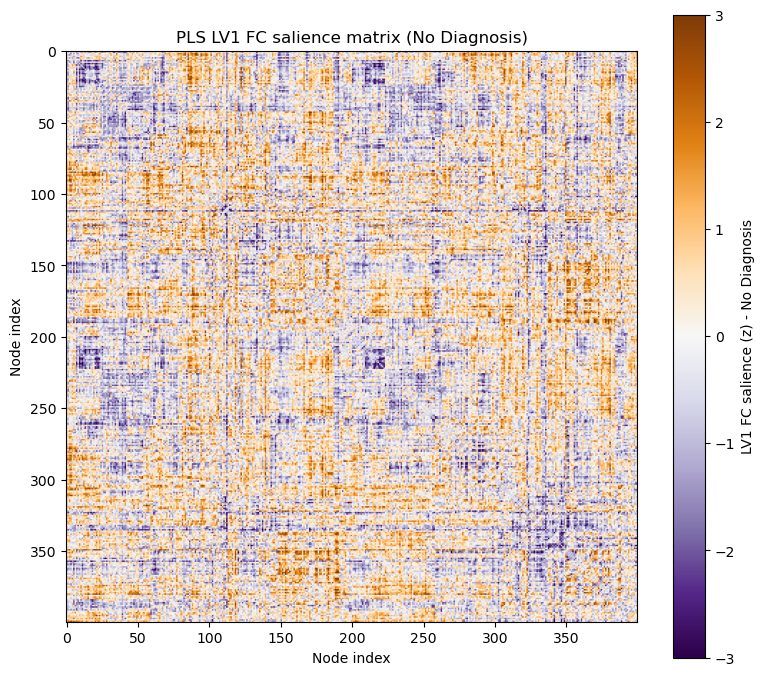

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("./new_figures", exist_ok=True)

# Extract data from no-diagnosis PLS results
X_saliences_nodx = results_nodx["X_saliences"]    # LV1 edge weights
iu_nodx = results_nodx["iu_indices"]              # upper-triangular indices
n_nodes_nodx = results_nodx["X_std"].shape[1]    # total features
n_edges_nodx = len(iu_nodx[0])
# compute number of nodes from edges (optional check)
n_nodes_nodx = int(np.round((1 + np.sqrt(1 + 8 * n_edges_nodx)) / 2))

# Reconstruct full symmetric FC matrix
sal_mat_nodx = np.zeros((n_nodes_nodx, n_nodes_nodx))
sal_mat_nodx[iu_nodx] = X_saliences_nodx
sal_mat_nodx = sal_mat_nodx + sal_mat_nodx.T  # symmetric

# Optionally z-score for visualization
sal_mat_z_nodx = (sal_mat_nodx - np.nanmean(sal_mat_nodx)) / np.nanstd(sal_mat_nodx)

# Plot heatmap
plt.figure(figsize=(8, 7))
plt.imshow(sal_mat_z_nodx, cmap="PuOr_r", vmin=-3, vmax=3)
plt.colorbar(label="LV1 FC salience (z) - No Diagnosis")
plt.title("PLS LV1 FC salience matrix (No Diagnosis)")
plt.xlabel("Node index")
plt.ylabel("Node index")
plt.tight_layout()

filename_nodx = './new_figures/LV1_salience_matrix_nodx.png'
plt.savefig(filename_nodx, dpi=150)
print(f"Saved {filename_nodx}")
plt.show()


## Permutation testing

In [121]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters for no-diagnosis PLS
# -------------------------------
n_permutations_nodx = 10000  # or fewer for testing, e.g., 1000
n_components_nodx = 1         # LV1 only
results_perm_nodx = {}        # store permutation p-values

print("Permutation testing for FC-based LV1 (No Diagnosis)...")

# Standardized X and Y from the no-diagnosis results dict
X_nodx = results_nodx['X_std']  # subjects × edges
Y_nodx = results_nodx['Y_std']  # subjects × behavioral vars

# -----------------------
# Fit original PLS
# -----------------------
pls_nodx = PLSRegression(n_components=n_components_nodx)
pls_nodx.fit(X_nodx, Y_nodx)

# Observed LV1 covariance (singular value)
X_scores_nodx = pls_nodx.x_scores_[:, 0]
Y_scores_nodx = pls_nodx.y_scores_[:, 0]
obs_singular_value_nodx = np.cov(X_scores_nodx, Y_scores_nodx, bias=True)[0, 1]

# -----------------------
# Run permutations
# -----------------------
perm_singular_values_nodx = np.zeros(n_permutations_nodx)
for i in range(n_permutations_nodx):
    # Shuffle rows of X
    X_perm_nodx = X_nodx[np.random.permutation(X_nodx.shape[0]), :]
    pls_perm_nodx = PLSRegression(n_components=n_components_nodx)
    pls_perm_nodx.fit(X_perm_nodx, Y_nodx)
    X_scores_perm_nodx = pls_perm_nodx.x_scores_[:, 0]
    Y_scores_perm_nodx = pls_perm_nodx.y_scores_[:, 0]
    perm_singular_values_nodx[i] = np.cov(X_scores_perm_nodx, Y_scores_perm_nodx, bias=True)[0, 1]

    # Optional: progress print
    if (i + 1) % 1000 == 0:
        print(f"  {i + 1} permutations done...")

# -----------------------
# Compute permutation p-value
# -----------------------
p_value_nodx = np.mean(perm_singular_values_nodx >= obs_singular_value_nodx)

# Store results in a dict (single FC result)
results_perm_nodx = {
    'obs_singular_value': obs_singular_value_nodx,
    'perm_singular_values': perm_singular_values_nodx,
    'p_value': p_value_nodx
}

print(f"FC LV1 permutation p-value (No Diagnosis): {p_value_nodx:.4f}")


Permutation testing for FC-based LV1 (No Diagnosis)...
  1000 permutations done...
  2000 permutations done...
  3000 permutations done...
  4000 permutations done...
  5000 permutations done...
  6000 permutations done...
  7000 permutations done...
  8000 permutations done...
  9000 permutations done...
  10000 permutations done...
FC LV1 permutation p-value (No Diagnosis): 0.4461


## Bootstrap resampling

Bootstrap resampling for FC-based LV1 (No Diagnosis)...
  500 / 5000 bootstraps done
  1000 / 5000 bootstraps done
  1500 / 5000 bootstraps done
  2000 / 5000 bootstraps done
  2500 / 5000 bootstraps done
  3000 / 5000 bootstraps done
  3500 / 5000 bootstraps done
  4000 / 5000 bootstraps done
  4500 / 5000 bootstraps done
  5000 / 5000 bootstraps done


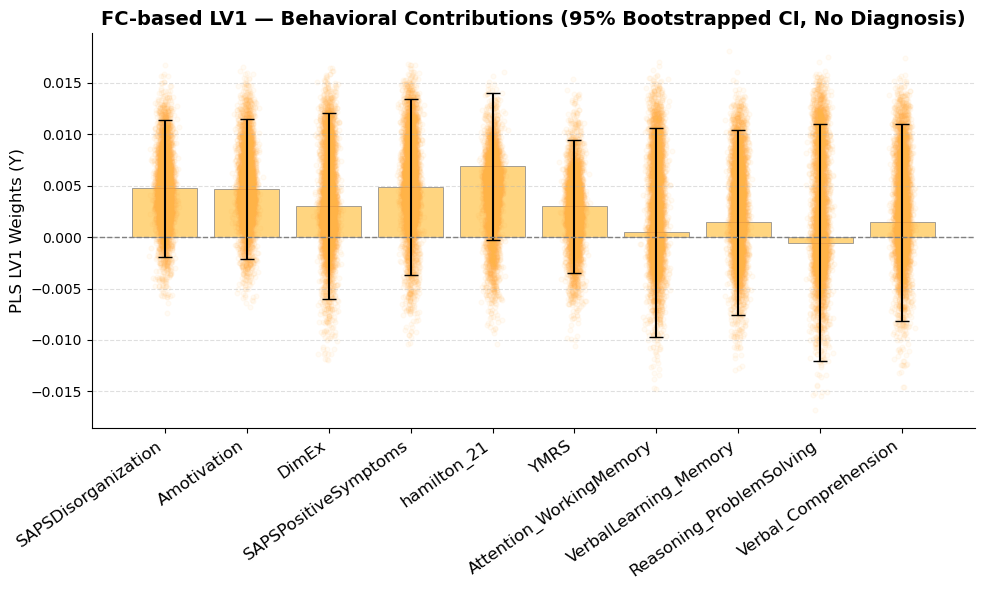

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters for no-diagnosis PLS
# -------------------------------
n_bootstrap_nodx = 5000   # or fewer for testing, e.g., 1000
n_components_nodx = 1     # LV1 only
results_boot_nodx = {}    # store bootstrap results

# Plot colors
bar_color_nodx = '#FFD580'
point_color_nodx = '#FFB347'
star_color_nodx = 'black'

print("Bootstrap resampling for FC-based LV1 (No Diagnosis)...")

# Standardized X and Y
X_nodx = results_nodx['X_std']  # subjects × edges
Y_nodx = results_nodx['Y_std']  # subjects × behavioral vars
n_subjects_nodx, n_edges_nodx = X_nodx.shape
n_behav_nodx = Y_nodx.shape[1]

# -----------------------
# Original PLS fit
# -----------------------
pls_orig_nodx = PLSRegression(n_components=n_components_nodx)
pls_orig_nodx.fit(X_nodx, Y_nodx)
X_orig_weights_nodx = pls_orig_nodx.x_weights_[:, 0]
Y_orig_weights_nodx = pls_orig_nodx.y_weights_[:, 0]

# -----------------------
# Bootstrap resampling
# -----------------------
X_boot_weights_nodx = np.zeros((n_bootstrap_nodx, n_edges_nodx))
Y_boot_weights_nodx = np.zeros((n_bootstrap_nodx, n_behav_nodx))

for i in range(n_bootstrap_nodx):
    # Resample subjects with replacement
    Xb_nodx, Yb_nodx = resample(X_nodx, Y_nodx, n_samples=n_subjects_nodx, replace=True)

    pls_boot_nodx = PLSRegression(n_components=n_components_nodx)
    pls_boot_nodx.fit(Xb_nodx, Yb_nodx)
    Xb_weights_nodx = pls_boot_nodx.x_weights_[:, 0]
    Yb_weights_nodx = pls_boot_nodx.y_weights_[:, 0]

    # -----------------------
    # Sign alignment (flip if reversed)
    # -----------------------
    if np.dot(Xb_weights_nodx, X_orig_weights_nodx) < 0:
        Xb_weights_nodx *= -1
        Yb_weights_nodx *= -1

    X_boot_weights_nodx[i, :] = Xb_weights_nodx
    Y_boot_weights_nodx[i, :] = Yb_weights_nodx

    if (i + 1) % 500 == 0:
        print(f"  {i + 1} / {n_bootstrap_nodx} bootstraps done")

# -----------------------
# Bootstrap ratios (BSR = weight / SD)
# -----------------------
X_bsr_nodx = X_orig_weights_nodx / X_boot_weights_nodx.std(axis=0)
Y_bsr_nodx = Y_orig_weights_nodx / Y_boot_weights_nodx.std(axis=0)

results_boot_nodx = {
    'X_bsr': X_bsr_nodx,
    'Y_bsr': Y_bsr_nodx,
    'X_boot_weights': X_boot_weights_nodx,
    'Y_boot_weights': Y_boot_weights_nodx
}

# -----------------------
# Behavioral bootstrap visualization (Y weights)
# -----------------------
y_mean_nodx = Y_orig_weights_nodx
y_sd_nodx = Y_boot_weights_nodx.std(axis=0)
lower_ci_nodx = y_mean_nodx - 1.96 * y_sd_nodx
upper_ci_nodx = y_mean_nodx + 1.96 * y_sd_nodx
significant_nodx = (lower_ci_nodx > 0) | (upper_ci_nodx < 0)

Y_cols_nodx = list(results_nodx['behav_corrs'].keys())
fig, ax = plt.subplots(figsize=(10, 6))

# Bars with error bars
ax.bar(
    np.arange(n_behav_nodx), y_mean_nodx,
    width=0.8,
    yerr=[y_mean_nodx - lower_ci_nodx, upper_ci_nodx - y_mean_nodx],
    capsize=5, color=bar_color_nodx, edgecolor='gray', linewidth=0.5
)

# Overlay bootstrap points (for distribution)
for j in range(n_behav_nodx):
    x = np.random.normal(j, 0.05, size=n_bootstrap_nodx)
    ax.scatter(x, Y_boot_weights_nodx[:, j], color=point_color_nodx, alpha=0.05, s=12)

# Zero line
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Significance stars
for j, sig in enumerate(significant_nodx):
    if sig:
        ax.text(j, upper_ci_nodx[j] + 0.02, "*", ha='center', va='bottom',
                fontsize=14, color=star_color_nodx, fontweight='bold')

ax.set_xticks(np.arange(n_behav_nodx))
ax.set_xticklabels(Y_cols_nodx, rotation=35, ha='right', fontsize=12)
ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
ax.set_title('FC-based LV1 — Behavioral Contributions (95% Bootstrapped CI, No Diagnosis)',
             fontsize=14, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


## Variance explained

Computing variance explained for FC-based PLS LV1 (No Diagnosis)...
LV1 explains 13.38% of X variance, 6.73% of Y variance, and 2951.51% shared variance.



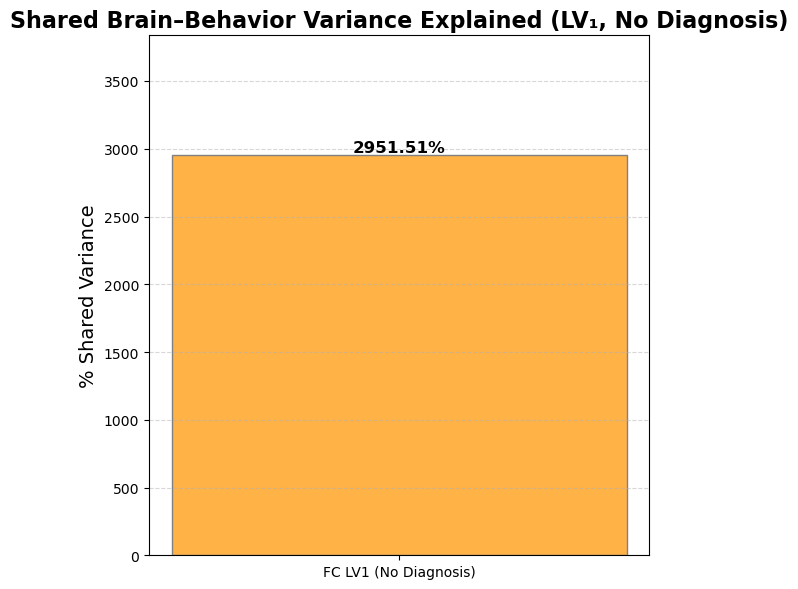

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for FC-based PLS LV1 (No Diagnosis)...")

X_nodx = results_nodx['X_std']
Y_nodx = results_nodx['Y_std']

pls_nodx = PLSRegression(n_components=1)
pls_nodx.fit(X_nodx, Y_nodx)

# Reconstruct predicted X and Y
X_pred_nodx = pls_nodx.x_scores_ @ pls_nodx.x_loadings_.T
Y_pred_nodx = pls_nodx.x_scores_ @ pls_nodx.y_loadings_.T

# Variance explained within each block
var_X_nodx = np.var(X_nodx, axis=0).sum()
var_Y_nodx = np.var(Y_nodx, axis=0).sum()
var_X_expl_nodx = np.var(X_pred_nodx, axis=0).sum() / var_X_nodx
var_Y_expl_nodx = np.var(Y_pred_nodx, axis=0).sum() / var_Y_nodx

# Shared cross-covariance variance explained
shared_var_nodx = (pls_nodx.x_scores_.T @ pls_nodx.y_scores_)**2 / (np.sum(X_nodx**2) * np.sum(Y_nodx**2))
shared_var_nodx = shared_var_nodx.item()

# Store in results dict
results_nodx['var_X_expl'] = var_X_expl_nodx
results_nodx['var_Y_expl'] = var_Y_expl_nodx
results_nodx['shared_var'] = shared_var_nodx

print(f"LV1 explains {var_X_expl_nodx * 100:.2f}% of X variance, "
      f"{var_Y_expl_nodx * 100:.2f}% of Y variance, "
      f"and {shared_var_nodx * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
plt.figure(figsize=(6, 6))
vals_nodx = [shared_var_nodx * 100]
plt.bar(['FC LV1 (No Diagnosis)'], vals_nodx, color=['#FFB347'], edgecolor='gray')

for i, v in enumerate(vals_nodx):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁, No Diagnosis)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.ylim(0, max(vals_nodx) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1_nodx.png", dpi=300)
plt.show()


## New variance explained

Computing variance explained for FC-based PLS LV1 (No Diagnosis)...
LV1 explains 13.38% of X variance, 6.73% of Y variance, 69.41% of total X–Y cross-covariance energy, and t–u squared correlation = 27.68%



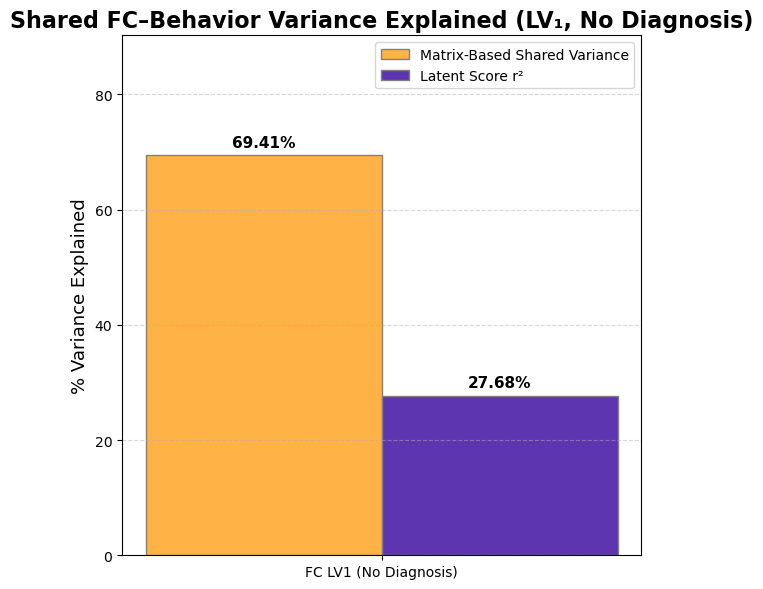


Saved figure to: new_figures/shared_variance_combined_FC_LV1_nodx.png


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# Create output folder
os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for FC-based PLS LV1 (No Diagnosis)...")

X_nodx = results_nodx['X_std']  # subjects × edges
Y_nodx = results_nodx['Y_std']  # subjects × behavioral vars
n_samples_nodx = X_nodx.shape[0]

pls_nodx = PLSRegression(n_components=1)
pls_nodx.fit(X_nodx, Y_nodx)

# Predicted components
X_pred_nodx = pls_nodx.x_scores_ @ pls_nodx.x_loadings_.T
Y_pred_nodx = pls_nodx.x_scores_ @ pls_nodx.y_loadings_.T

# Variance explained
var_X_expl_nodx = np.sum(X_pred_nodx**2) / np.sum(X_nodx**2)
var_Y_expl_nodx = np.sum(Y_pred_nodx**2) / np.sum(Y_nodx**2)

# Shared variance (matrix-based)
C_full_nodx = (X_nodx.T @ Y_nodx) / (n_samples_nodx - 1)
C_pred_nodx = (X_pred_nodx.T @ Y_pred_nodx) / (n_samples_nodx - 1)
total_cross_energy_nodx = np.sum(C_full_nodx**2)
explained_cross_energy_nodx = np.sum(C_pred_nodx**2)
shared_var_matrix_nodx = 0.0 if total_cross_energy_nodx == 0 else explained_cross_energy_nodx / total_cross_energy_nodx

# Latent score correlation (t–u)
t_nodx = pls_nodx.x_scores_[:, 0]
u_nodx = pls_nodx.y_scores_[:, 0]
r2_latent_nodx = np.corrcoef(t_nodx, u_nodx)[0, 1]**2

# Store in results dict
results_nodx['var_X_expl'] = var_X_expl_nodx
results_nodx['var_Y_expl'] = var_Y_expl_nodx
results_nodx['shared_var_matrix'] = shared_var_matrix_nodx
results_nodx['r2_latent'] = r2_latent_nodx

print(f"LV1 explains {var_X_expl_nodx*100:.2f}% of X variance, "
      f"{var_Y_expl_nodx*100:.2f}% of Y variance, "
      f"{shared_var_matrix_nodx*100:.2f}% of total X–Y cross-covariance energy, "
      f"and t–u squared correlation = {r2_latent_nodx*100:.2f}%\n")

# --- Plot combined bars ---
vals_matrix_nodx = [shared_var_matrix_nodx * 100]
vals_latent_nodx = [r2_latent_nodx * 100]
labels_nodx = ['FC LV1 (No Diagnosis)']

x_nodx = np.arange(len(labels_nodx))
width_nodx = 0.35

plt.figure(figsize=(6, 6))
plt.bar(x_nodx - width_nodx/2, vals_matrix_nodx, width_nodx, label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray')
plt.bar(x_nodx + width_nodx/2, vals_latent_nodx, width_nodx, label='Latent Score r²',
        color='#5E35B1', edgecolor='gray')

# Annotate
for i in range(len(labels_nodx)):
    plt.text(x_nodx[i] - width_nodx/2, vals_matrix_nodx[i] + 1, f"{vals_matrix_nodx[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x_nodx[i] + width_nodx/2, vals_latent_nodx[i] + 1, f"{vals_latent_nodx[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x_nodx, labels_nodx)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared FC–Behavior Variance Explained (LV₁, No Diagnosis)", fontsize=16, fontweight='bold')
plt.ylim(0, max(vals_matrix_nodx[0], vals_latent_nodx[0]) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_FC_LV1_nodx.png", dpi=300)
plt.show()

print("\nSaved figure to: new_figures/shared_variance_combined_FC_LV1_nodx.png")


# Upper 10% FC without diagnosis

In [1]:
import numpy as np
import pandas as pd
import glob
import re
import os
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Config / user options
# ------------------------
grad_csv_path = './g1_aligned_cog.csv'
fc_dir_glob = "./BD-SCZ/RSFC_HC_SCZ_BD_noGSR/sub*.mat"
pid_column_candidates = ['participant_id_num', 'participant_id', 'ID', 'id']
n_nodes_expected = 400
apply_fisher = True
top_nodx_percent = 0.1  # keep top_nodx 10% strongest FC edges

# ------------------------
# Helper functions
# ------------------------
def ensure_numeric_encoding(df, col):
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in dataframe.")
    if np.issubdtype(df[col].dtype, np.number):
        return df
    if col.lower() == 'gender':
        mapping_candidates = {'male': 0, 'm': 0, 'female': 1, 'f': 1}
        uniques = pd.Series(df[col].dropna().astype(str).str.lower().unique())
        mapping = {val: mapping_candidates.get(val, i) for i, val in enumerate(uniques)}
        df[col] = df[col].astype(str).str.lower().map(mapping)
        print(f"Auto-mapped '{col}' (gender-special): {mapping}")
        return df
    uniques = sorted(df[col].dropna().astype(str).unique())
    mapping = {val: i for i, val in enumerate(uniques)}
    df[col] = df[col].astype(str).map(mapping)
    print(f"Auto-mapped '{col}': {mapping}")
    return df

def regress_out(X, covariates):
    X = np.asarray(X, dtype=float)
    covariates = np.asarray(covariates, dtype=float)
    if covariates.ndim == 1:
        covariates = covariates.reshape(-1, 1)
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        y = X[:, j]
        lr = LinearRegression().fit(covariates, y)
        y_pred = lr.predict(covariates)
        X_resid[:, j] = y - y_pred
    return X_resid

# ------------------------
# Load gradient CSV
# ------------------------
grad_df = pd.read_csv(grad_csv_path)
print(f"Loaded gradient CSV: {grad_csv_path} (shape: {grad_df.shape})")

# detect participant id column
pid_col = None
for c in pid_column_candidates:
    if c in grad_df.columns:
        pid_col = c
        break
if pid_col is None:
    for c in grad_df.columns:
        nonnull = grad_df[c].dropna().astype(str)
        if nonnull.apply(lambda s: bool(re.fullmatch(r'\d+', s))).all():
            pid_col = c
            break
if pid_col is None:
    raise ValueError("Could not detect participant ID column in gradient CSV.")
grad_df[pid_col] = grad_df[pid_col].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()
print(f"Using participant id column: '{pid_col}'")

# ------------------------
# Load FC matrices
# ------------------------
files = np.sort(glob.glob(fc_dir_glob))
if len(files) == 0:
    raise FileNotFoundError(f"No FC files found with pattern: {fc_dir_glob}")

fc_top_nodx = {}
for f in files:
    try:
        matdict = loadmat(f)
        mat = np.asarray(matdict['subj_final_corr_mat'], dtype=float)
    except Exception as e:
        print(f"Skipping {f}: {e}")
        continue
    if mat.shape[0] != mat.shape[1] or mat.shape[0] < n_nodes_expected:
        continue
    if mat.shape[0] != n_nodes_expected:
        mat = mat[:n_nodes_expected, :n_nodes_expected]
    if not np.allclose(mat, mat.T, atol=1e-6):
        mat = 0.5 * (mat + mat.T)
    match = re.search(r"sub-?(\d+)", os.path.basename(f))
    if not match:
        continue
    pid = match.group(1).lstrip('0') or match.group(1)
    fc_top_nodx[pid] = mat

print(f"Total FC files loaded for top_nodx 10% edges: {len(fc_top_nodx)}")

# ------------------------
# Match participants
# ------------------------
available_pids = set(fc_top_nodx.keys())
patient_df_top_nodx = grad_df[grad_df['diagnosis'].isin([2,3]) & grad_df[pid_col].isin(available_pids)].copy()
for col in ['gender', 'diagnosis']:
    patient_df_top_nodx = ensure_numeric_encoding(patient_df_top_nodx, col)

# ------------------------
# Build FC feature matrix (top_nodx 10% strongest edges)
# ------------------------
first_pid = next(iter(fc_top_nodx))
n_nodes = fc_top_nodx[first_pid].shape[0]
iu = np.triu_indices(n_nodes, k=1)
n_edges = len(iu[0])
top_nodx_n_edges = int(n_edges * top_nodx_percent)
print(f"Keeping top_nodx {top_nodx_percent*100:.1f}% edges ({top_nodx_n_edges} of {n_edges})")

# Determine absolute edge threshold across all subjects
all_edges = np.vstack([np.abs(fc_top_nodx[pid][iu]) for pid in fc_top_nodx])
threshold = np.percentile(all_edges, 100 - top_nodx_percent*100)

X_list_top_nodx = []
pids_used_top_nodx = []
for pid in patient_df_top_nodx[pid_col]:
    if pid not in fc_top_nodx:
        continue
    mat = fc_top_nodx[pid]
    if apply_fisher:
        mat = np.arctanh(np.clip(mat, -0.999999, 0.999999))
    edges = mat[iu]
    # keep only top_nodx 10% strongest edges by magnitude
    mask_top_nodx = np.abs(edges) >= threshold
    X_list_top_nodx.append(edges[mask_top_nodx])
    pids_used_top_nodx.append(pid)

# Pad or truncate columns to consistent shape
max_edges = max(len(x) for x in X_list_top_nodx)
X_top_nodx = np.array([np.pad(x, (0, max_edges - len(x)), 'constant') for x in X_list_top_nodx])
print(f"Built top_nodx 10% FC feature matrix X_top_nodx with shape: {X_top_nodx.shape}")

# ------------------------
# Reindex patient_df
# ------------------------
patient_df_top_nodx = patient_df_top_nodx.set_index(pid_col).loc[pids_used_top_nodx].reset_index()

# ------------------------
# Create cognitive domain scores
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

for group_name, var_list in group_definitions.items():
    zscored = patient_df_top_nodx[var_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
    domain_score = -zscored.mean(axis=1)
    patient_df_top_nodx[group_name] = domain_score

# ------------------------
# Build Y
# ------------------------
other_vars = ['SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']
Y_cols_top_nodx = other_vars + list(group_definitions.keys())
Y_top_nodx = patient_df_top_nodx[Y_cols_top_nodx].values

# ------------------------
# Remove NaNs
# ------------------------
valid_mask_top_nodx = ~(np.isnan(X_top_nodx).any(axis=1) | np.isnan(Y_top_nodx).any(axis=1))
X_top_nodx_valid = X_top_nodx[valid_mask_top_nodx]
Y_top_nodx_valid = Y_top_nodx[valid_mask_top_nodx]
patient_df_top_nodx_valid = patient_df_top_nodx.loc[valid_mask_top_nodx].reset_index(drop=True)

# ------------------------
# Regress out covariates
# ------------------------
covars_top_nodx = patient_df_top_nodx_valid[['age', 'gender']].values
X_top_nodx_resid = regress_out(X_top_nodx_valid, covars_top_nodx)

# ------------------------
# Standardize
# ------------------------
X_top_nodx_std = StandardScaler().fit_transform(X_top_nodx_resid)
Y_top_nodx_std = StandardScaler().fit_transform(Y_top_nodx_valid)

# ------------------------
# PLS LV1
# ------------------------
pls_top_nodx = PLSRegression(n_components=1)
pls_top_nodx.fit(X_top_nodx_std, Y_top_nodx_std)
X_top_nodx_saliences = pls_top_nodx.x_weights_[:,0]
Y_top_nodx_saliences = pls_top_nodx.y_weights_[:,0]
X_top_nodx_scores = pls_top_nodx.x_scores_[:,0]
Y_top_nodx_scores = pls_top_nodx.y_scores_[:,0]

# ------------------------
# Behavioral correlations
# ------------------------
behav_corrs_top_nodx = {}
behav_pvals_top_nodx = {}
for i, var in enumerate(Y_cols_top_nodx):
    try:
        corr, pval = pearsonr(Y_top_nodx_std[:, i], Y_top_nodx_scores)
    except Exception:
        corr, pval = np.nan, np.nan
    behav_corrs_top_nodx[var] = corr
    behav_pvals_top_nodx[var] = pval

# ------------------------
# Save results
# ------------------------
results_top_nodx10 = {
    'X_saliences': X_top_nodx_saliences,
    'Y_saliences': Y_top_nodx_saliences,
    'X_scores': X_top_nodx_scores,
    'Y_scores': Y_top_nodx_scores,
    'behav_corrs': behav_corrs_top_nodx,
    'behav_pvals': behav_pvals_top_nodx,
    'patient_df_valid': patient_df_top_nodx_valid,
    'X_std': X_top_nodx_std,
    'Y_std': Y_top_nodx_std,
    'pids_used': pids_used_top_nodx,
    'threshold_top_nodx_edges': threshold
}

print("\nTop 10% FC LV1 PLS complete. Results are stored in `results_top_nodx10`.")


Loaded gradient CSV: ./g1_aligned_cog.csv (shape: (187, 438))
Using participant id column: 'participant_id_num'
Total FC files loaded for top_nodx 10% edges: 187
Keeping top_nodx 10.0% edges (7980 of 79800)
Built top_nodx 10% FC feature matrix X_top_nodx with shape: (77, 42064)

Top 10% FC LV1 PLS complete. Results are stored in `results_top_nodx10`.


## Permutation testing

In [3]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations_top_nodx10 = 10000  # or fewer for testing, e.g., 1000
n_components_top_nodx10 = 1         # LV1 only
results_perm_top_nodx10 = {}        # store permutation p-values

print("Permutation testing for Top 10% FC LV1...")

# Standardized X and Y from the top_nodx10% results
X_top_nodx10 = results_top_nodx10['X_std']  # subjects × top_nodx edges
Y_top_nodx10 = results_top_nodx10['Y_std']  # subjects × behavioral vars

# -----------------------
# Fit original PLS
# -----------------------
pls_top_nodx10 = PLSRegression(n_components=n_components_top_nodx10)
pls_top_nodx10.fit(X_top_nodx10, Y_top_nodx10)

# Observed LV1 covariance (singular value)
X_scores_top_nodx10 = pls_top_nodx10.x_scores_[:, 0]
Y_scores_top_nodx10 = pls_top_nodx10.y_scores_[:, 0]
obs_singular_value_top_nodx10 = np.cov(X_scores_top_nodx10, Y_scores_top_nodx10, bias=True)[0, 1]

# -----------------------
# Run permutations
# -----------------------
perm_singular_values_top_nodx10 = np.zeros(n_permutations_top_nodx10)
for i in range(n_permutations_top_nodx10):
    # Shuffle rows of X
    X_perm_top_nodx10 = X_top_nodx10[np.random.permutation(X_top_nodx10.shape[0]), :]
    pls_perm_top_nodx10 = PLSRegression(n_components=n_components_top_nodx10)
    pls_perm_top_nodx10.fit(X_perm_top_nodx10, Y_top_nodx10)
    X_scores_perm_top_nodx10 = pls_perm_top_nodx10.x_scores_[:, 0]
    Y_scores_perm_top_nodx10 = pls_perm_top_nodx10.y_scores_[:, 0]
    perm_singular_values_top_nodx10[i] = np.cov(X_scores_perm_top_nodx10, Y_scores_perm_top_nodx10, bias=True)[0, 1]

    # Optional: progress print
    if (i + 1) % 1000 == 0:
        print(f"  {i + 1} permutations done...")

# -----------------------
# Compute permutation p-value
# -----------------------
p_value_top_nodx10 = np.mean(perm_singular_values_top_nodx10 >= obs_singular_value_top_nodx10)

# Store results in a dict
results_perm_top_nodx10 = {
    'obs_singular_value': obs_singular_value_top_nodx10,
    'perm_singular_values': perm_singular_values_top_nodx10,
    'p_value': p_value_top_nodx10
}

print(f"Top 10% FC LV1 permutation p-value: {p_value_top_nodx10:.4f}")


Permutation testing for Top 10% FC LV1...
  1000 permutations done...
  2000 permutations done...
  3000 permutations done...
  4000 permutations done...
  5000 permutations done...
  6000 permutations done...
  7000 permutations done...
  8000 permutations done...
  9000 permutations done...
  10000 permutations done...
Top 10% FC LV1 permutation p-value: 0.2779


## Bootstrap resampling

Bootstrap resampling for Top 10% FC LV1...
  500 / 5000 bootstraps done
  1000 / 5000 bootstraps done
  1500 / 5000 bootstraps done
  2000 / 5000 bootstraps done
  2500 / 5000 bootstraps done
  3000 / 5000 bootstraps done
  3500 / 5000 bootstraps done
  4000 / 5000 bootstraps done
  4500 / 5000 bootstraps done
  5000 / 5000 bootstraps done


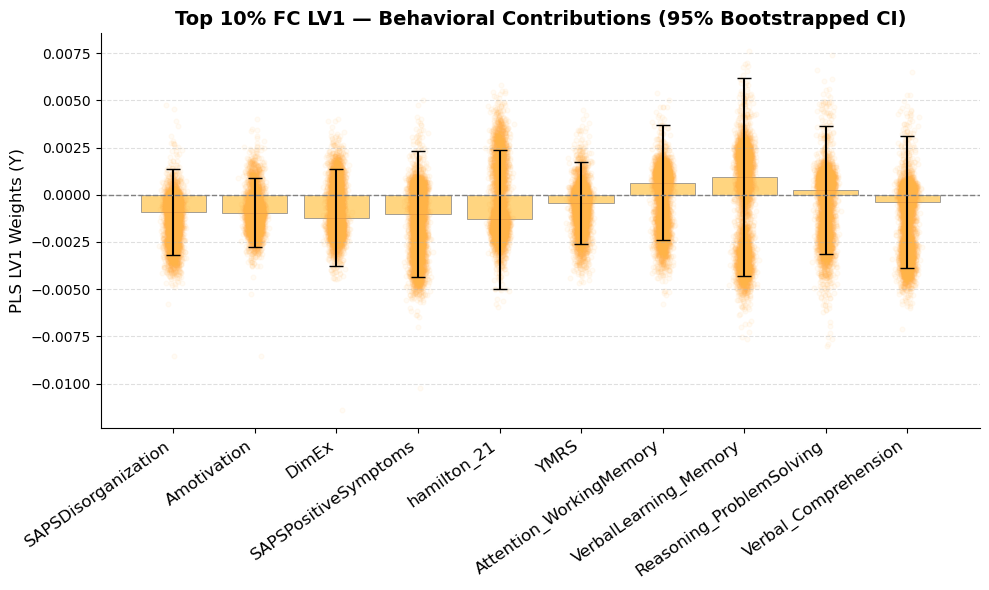

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap_top_nodx10 = 5000   # or fewer for testing, e.g., 1000
n_components_top_nodx10 = 1     # LV1 only
results_boot_top_nodx10 = {}    # store bootstrap results

# Plot colors
bar_color_top_nodx10 = '#FFD580'
point_color_top_nodx10 = '#FFB347'
star_color_top_nodx10 = 'black'

print("Bootstrap resampling for Top 10% FC LV1...")

# Standardized X and Y
X_top_nodx10 = results_top_nodx10['X_std']  # subjects × top_nodx edges
Y_top_nodx10 = results_top_nodx10['Y_std']  # subjects × behavioral vars
n_subjects_top_nodx10, n_edges_top_nodx10 = X_top_nodx10.shape
n_behav_top_nodx10 = Y_top_nodx10.shape[1]

# -----------------------
# Original PLS fit
# -----------------------
pls_orig_top_nodx10 = PLSRegression(n_components=n_components_top_nodx10)
pls_orig_top_nodx10.fit(X_top_nodx10, Y_top_nodx10)
X_orig_weights_top_nodx10 = pls_orig_top_nodx10.x_weights_[:, 0]
Y_orig_weights_top_nodx10 = pls_orig_top_nodx10.y_weights_[:, 0]

# -----------------------
# Bootstrap resampling
# -----------------------
X_boot_weights_top_nodx10 = np.zeros((n_bootstrap_top_nodx10, n_edges_top_nodx10))
Y_boot_weights_top_nodx10 = np.zeros((n_bootstrap_top_nodx10, n_behav_top_nodx10))

for i in range(n_bootstrap_top_nodx10):
    # Resample subjects with replacement
    Xb_top_nodx10, Yb_top_nodx10 = resample(X_top_nodx10, Y_top_nodx10, n_samples=n_subjects_top_nodx10, replace=True)

    pls_boot_top_nodx10 = PLSRegression(n_components=n_components_top_nodx10)
    pls_boot_top_nodx10.fit(Xb_top_nodx10, Yb_top_nodx10)
    Xb_weights_top_nodx10 = pls_boot_top_nodx10.x_weights_[:, 0]
    Yb_weights_top_nodx10 = pls_boot_top_nodx10.y_weights_[:, 0]

    # -----------------------
    # Sign alignment (flip if reversed)
    # -----------------------
    if np.dot(Xb_weights_top_nodx10, X_orig_weights_top_nodx10) < 0:
        Xb_weights_top_nodx10 *= -1
        Yb_weights_top_nodx10 *= -1

    X_boot_weights_top_nodx10[i, :] = Xb_weights_top_nodx10
    Y_boot_weights_top_nodx10[i, :] = Yb_weights_top_nodx10

    if (i + 1) % 500 == 0:
        print(f"  {i + 1} / {n_bootstrap_top_nodx10} bootstraps done")

# -----------------------
# Bootstrap ratios (BSR = weight / SD)
# -----------------------
X_bsr_top_nodx10 = X_orig_weights_top_nodx10 / X_boot_weights_top_nodx10.std(axis=0)
Y_bsr_top_nodx10 = Y_orig_weights_top_nodx10 / Y_boot_weights_top_nodx10.std(axis=0)

results_boot_top_nodx10 = {
    'X_bsr': X_bsr_top_nodx10,
    'Y_bsr': Y_bsr_top_nodx10,
    'X_boot_weights': X_boot_weights_top_nodx10,
    'Y_boot_weights': Y_boot_weights_top_nodx10
}

# -----------------------
# Behavioral bootstrap visualization (Y weights)
# -----------------------
y_mean_top_nodx10 = Y_orig_weights_top_nodx10
y_sd_top_nodx10 = Y_boot_weights_top_nodx10.std(axis=0)
lower_ci_top_nodx10 = y_mean_top_nodx10 - 1.96 * y_sd_top_nodx10
upper_ci_top_nodx10 = y_mean_top_nodx10 + 1.96 * y_sd_top_nodx10
significant_top_nodx10 = (lower_ci_top_nodx10 > 0) | (upper_ci_top_nodx10 < 0)

Y_cols_top_nodx10 = list(results_top_nodx10['behav_corrs'].keys())
fig, ax = plt.subplots(figsize=(10, 6))

# Bars with error bars
ax.bar(
    np.arange(n_behav_top_nodx10), y_mean_top_nodx10,
    width=0.8,
    yerr=[y_mean_top_nodx10 - lower_ci_top_nodx10, upper_ci_top_nodx10 - y_mean_top_nodx10],
    capsize=5, color=bar_color_top_nodx10, edgecolor='gray', linewidth=0.5
)

# Overlay bootstrap points (for distribution)
for j in range(n_behav_top_nodx10):
    x = np.random.normal(j, 0.05, size=n_bootstrap_top_nodx10)
    ax.scatter(x, Y_boot_weights_top_nodx10[:, j], color=point_color_top_nodx10, alpha=0.05, s=12)

# Zero line
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Significance stars
for j, sig in enumerate(significant_top_nodx10):
    if sig:
        ax.text(j, upper_ci_top_nodx10[j] + 0.02, "*", ha='center', va='bottom',
                fontsize=14, color=star_color_top_nodx10, fontweight='bold')

ax.set_xticks(np.arange(n_behav_top_nodx10))
ax.set_xticklabels(Y_cols_top_nodx10, rotation=35, ha='right', fontsize=12)
ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
ax.set_title('Top 10% FC LV1 — Behavioral Contributions (95% Bootstrapped CI)',
             fontsize=14, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()


## Variance explained

Computing variance explained for Top 10% FC PLS LV1...
Top 10% FC LV1 explains 46.24% of X variance, 1.31% of Y variance, and 70498.03% shared variance.



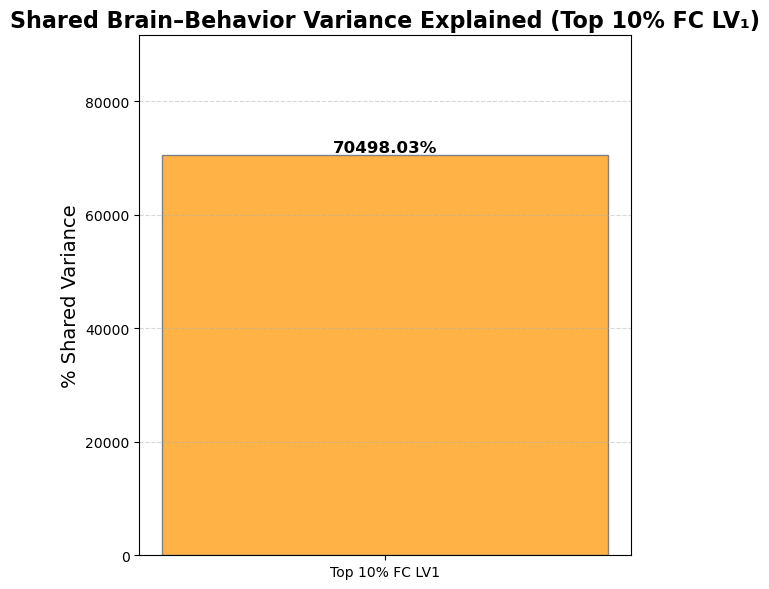

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for Top 10% FC PLS LV1...")

# Standardized X and Y for top_nodx 10% edges
X_top_nodx10 = results_top_nodx10['X_std']
Y_top_nodx10 = results_top_nodx10['Y_std']

# Fit PLS
pls_top_nodx10 = PLSRegression(n_components=1)
pls_top_nodx10.fit(X_top_nodx10, Y_top_nodx10)

# Reconstruct predicted X and Y
X_pred_top_nodx10 = pls_top_nodx10.x_scores_ @ pls_top_nodx10.x_loadings_.T
Y_pred_top_nodx10 = pls_top_nodx10.x_scores_ @ pls_top_nodx10.y_loadings_.T

# Variance explained within each block
var_X_top_nodx10 = np.var(X_top_nodx10, axis=0).sum()
var_Y_top_nodx10 = np.var(Y_top_nodx10, axis=0).sum()
var_X_expl_top_nodx10 = np.var(X_pred_top_nodx10, axis=0).sum() / var_X_top_nodx10
var_Y_expl_top_nodx10 = np.var(Y_pred_top_nodx10, axis=0).sum() / var_Y_top_nodx10

# Shared cross-covariance variance explained
shared_var_top_nodx10 = (pls_top_nodx10.x_scores_.T @ pls_top_nodx10.y_scores_)**2 / (np.sum(X_top_nodx10**2) * np.sum(Y_top_nodx10**2))
shared_var_top_nodx10 = shared_var_top_nodx10.item()

# Store in results_top_nodx10 dict
results_top_nodx10['var_X_expl'] = var_X_expl_top_nodx10
results_top_nodx10['var_Y_expl'] = var_Y_expl_top_nodx10
results_top_nodx10['shared_var'] = shared_var_top_nodx10

print(f"Top 10% FC LV1 explains {var_X_expl_top_nodx10 * 100:.2f}% of X variance, "
      f"{var_Y_expl_top_nodx10 * 100:.2f}% of Y variance, "
      f"and {shared_var_top_nodx10 * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
plt.figure(figsize=(6, 6))
vals_top_nodx10 = [shared_var_top_nodx10 * 100]
plt.bar(['Top 10% FC LV1'], vals_top_nodx10, color=['#FFB347'], edgecolor='gray')

for i, v in enumerate(vals_top_nodx10):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (Top 10% FC LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.ylim(0, max(vals_top_nodx10) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1_top_nodx10.png", dpi=300)
plt.show()


## New variance explained

Computing variance explained for Top 10% FC PLS LV1...
Top 10% FC LV1 explains 46.24% of X variance, 1.31% of Y variance, 51.77% of total X–Y cross-covariance energy, and t–u squared correlation = 7.35%



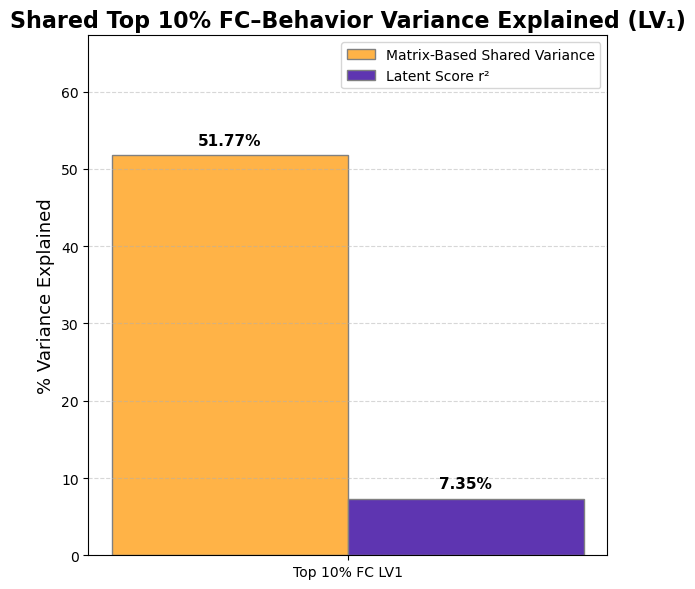


Saved figure to: new_figures/shared_variance_combined_FC_LV1_top_nodx10.png


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# Create output folder
os.makedirs("new_figures", exist_ok=True)

print("Computing variance explained for Top 10% FC PLS LV1...")

# Standardized X and Y for top_nodx 10% edges
X_top_nodx10 = results_top_nodx10['X_std']  # subjects × top_nodx 10% edges
Y_top_nodx10 = results_top_nodx10['Y_std']  # subjects × behavioral vars
n_samples_top_nodx10 = X_top_nodx10.shape[0]

# Fit PLS
pls_top_nodx10 = PLSRegression(n_components=1)
pls_top_nodx10.fit(X_top_nodx10, Y_top_nodx10)

# Predicted components
X_pred_top_nodx10 = pls_top_nodx10.x_scores_ @ pls_top_nodx10.x_loadings_.T
Y_pred_top_nodx10 = pls_top_nodx10.x_scores_ @ pls_top_nodx10.y_loadings_.T

# Variance explained
var_X_expl_top_nodx10 = np.sum(X_pred_top_nodx10**2) / np.sum(X_top_nodx10**2)
var_Y_expl_top_nodx10 = np.sum(Y_pred_top_nodx10**2) / np.sum(Y_top_nodx10**2)

# Shared variance (matrix-based)
C_full_top_nodx10 = (X_top_nodx10.T @ Y_top_nodx10) / (n_samples_top_nodx10 - 1)
C_pred_top_nodx10 = (X_pred_top_nodx10.T @ Y_pred_top_nodx10) / (n_samples_top_nodx10 - 1)
total_cross_energy_top_nodx10 = np.sum(C_full_top_nodx10**2)
explained_cross_energy_top_nodx10 = np.sum(C_pred_top_nodx10**2)
shared_var_matrix_top_nodx10 = 0.0 if total_cross_energy_top_nodx10 == 0 else explained_cross_energy_top_nodx10 / total_cross_energy_top_nodx10

# Latent score correlation (t–u)
t_top_nodx10 = pls_top_nodx10.x_scores_[:, 0]
u_top_nodx10 = pls_top_nodx10.y_scores_[:, 0]
r2_latent_top_nodx10 = np.corrcoef(t_top_nodx10, u_top_nodx10)[0, 1]**2

# Store in results_top_nodx10 dict
results_top_nodx10['var_X_expl'] = var_X_expl_top_nodx10
results_top_nodx10['var_Y_expl'] = var_Y_expl_top_nodx10
results_top_nodx10['shared_var_matrix'] = shared_var_matrix_top_nodx10
results_top_nodx10['r2_latent'] = r2_latent_top_nodx10

print(f"Top 10% FC LV1 explains {var_X_expl_top_nodx10*100:.2f}% of X variance, "
      f"{var_Y_expl_top_nodx10*100:.2f}% of Y variance, "
      f"{shared_var_matrix_top_nodx10*100:.2f}% of total X–Y cross-covariance energy, "
      f"and t–u squared correlation = {r2_latent_top_nodx10*100:.2f}%\n")

# --- Plot combined bars ---
vals_matrix_top_nodx10 = [shared_var_matrix_top_nodx10 * 100]
vals_latent_top_nodx10 = [r2_latent_top_nodx10 * 100]
labels_top_nodx10 = ['Top 10% FC LV1']

x = np.arange(len(labels_top_nodx10))
width = 0.35

plt.figure(figsize=(6, 6))
plt.bar(x - width/2, vals_matrix_top_nodx10, width, label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray')
plt.bar(x + width/2, vals_latent_top_nodx10, width, label='Latent Score r²',
        color='#5E35B1', edgecolor='gray')

# Annotate bars
for i in range(len(labels_top_nodx10)):
    plt.text(x[i] - width/2, vals_matrix_top_nodx10[i] + 1, f"{vals_matrix_top_nodx10[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, vals_latent_top_nodx10[i] + 1, f"{vals_latent_top_nodx10[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, labels_top_nodx10)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Top 10% FC–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylim(0, max(vals_matrix_top_nodx10[0], vals_latent_top_nodx10[0]) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_FC_LV1_top_nodx10.png", dpi=300)
plt.show()

print("\nSaved figure to: new_figures/shared_variance_combined_FC_LV1_top_nodx10.png")
